In [1]:
%matplotlib inline
import gzip
import itertools
from datetime import datetime

import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
from collections import Counter
from joblib import Parallel, delayed
import pathlib
import copy

In [2]:
input_folder = "gamergate/mallet"
output_folder = "gamergate/output"
date_format = "%Y-%m-%d.txt"
title = "GamerGate"

In [3]:
def import_doc_topics():
    # Import topics
    names = []
    topics_inner = []
    with open(f"{input_folder}/doc_topics.txt") as f:
        for row in f.readlines():
            index, name, *value = row.split()
            stack = np.array([float(i) for i in value])
            filtered = name.split("/")[-1]
            names.append(filtered)
            topics_inner.append(stack)

    dates_inner = [datetime.strptime(i, date_format) for i in names]
    topics_inner = np.row_stack(topics_inner)
    return dates_inner, topics_inner, names

dates, topics, names = import_doc_topics()

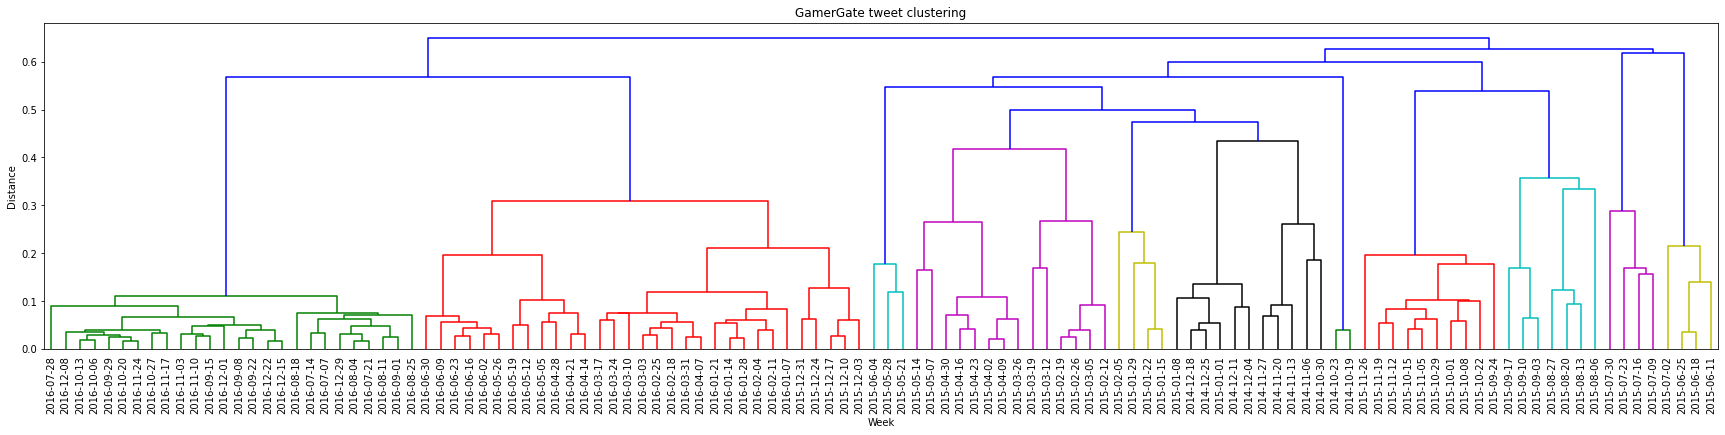

In [4]:
# Generate Dendrogram
def graph_dendrogram(data):
    # Generate distance matrix.
    distances = []
    for x, y in itertools.combinations(range(data.shape[0]), 2):
        distances.append(jensenshannon(data[x], data[y], 2))

    z = hierarchy.linkage(distances, 'average', optimal_ordering=True)
    labels = [f"{i.year}-{str(i.month).zfill(2)}-{str(i.day).zfill(2)}" for i in dates]

    # Create graph
    fig, ax = plt.subplots(figsize=(30,6))
    hierarchy.dendrogram(z, labels=labels, leaf_rotation=90, ax=ax)
    ax.tick_params(axis="x", labelsize=10)
    ax.set_title(f"{title} tweet clustering")
    ax.set_xlabel("Week")
    ax.set_ylabel("Distance")
    fig.savefig(f"{output_folder}/cluster.png")

# Graph dendrogram
graph_dendrogram(topics)

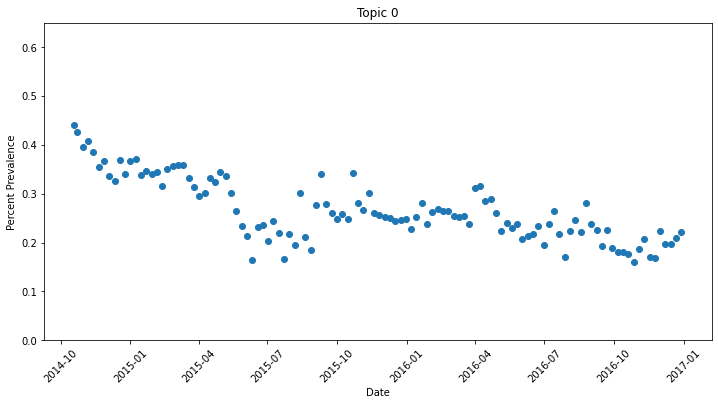

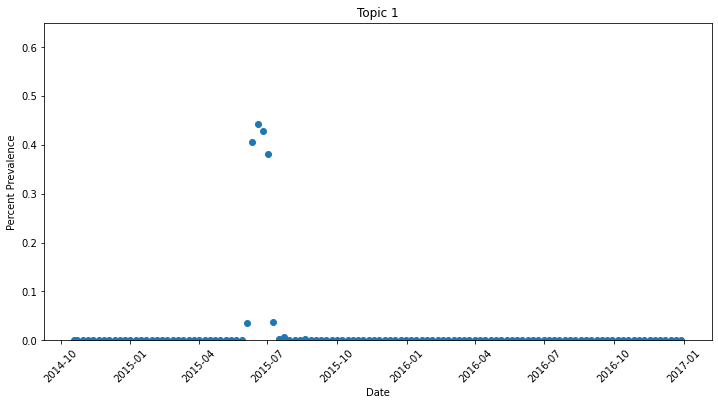

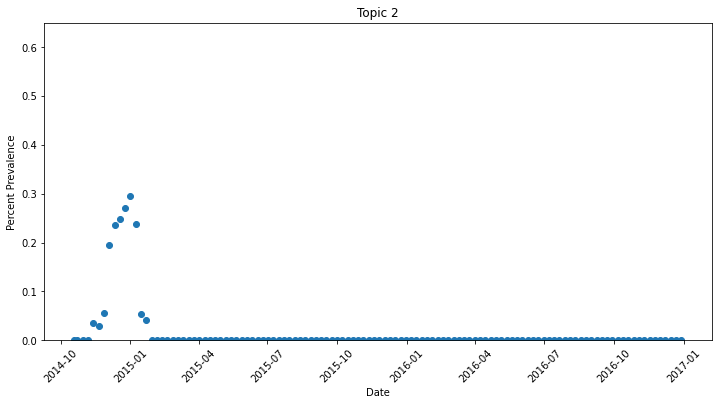

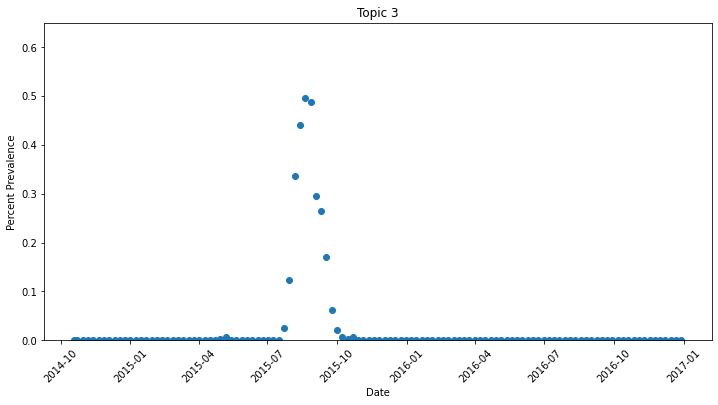

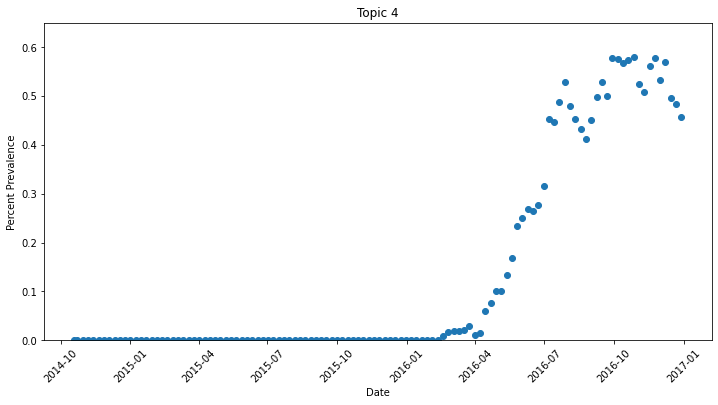

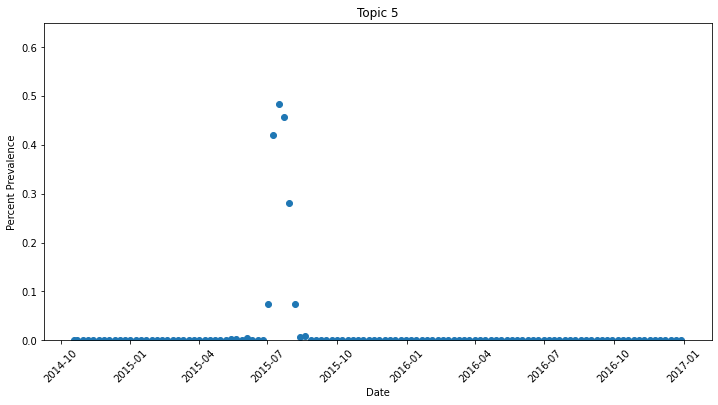

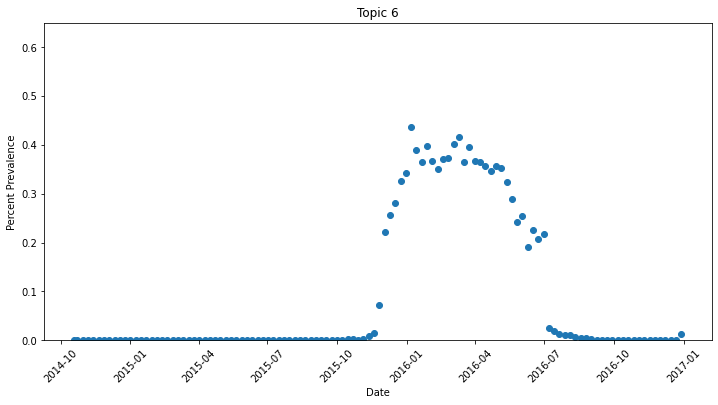

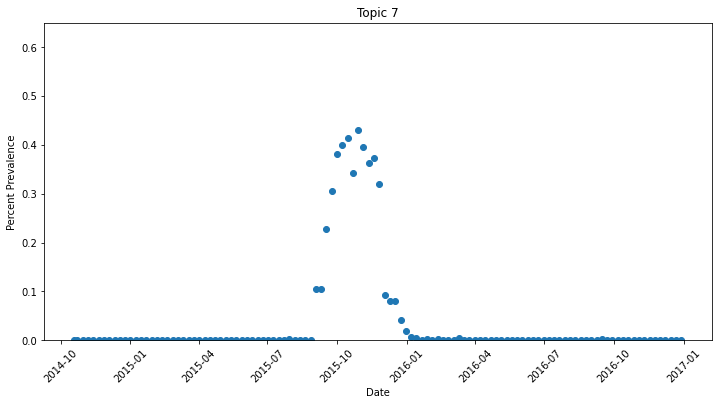

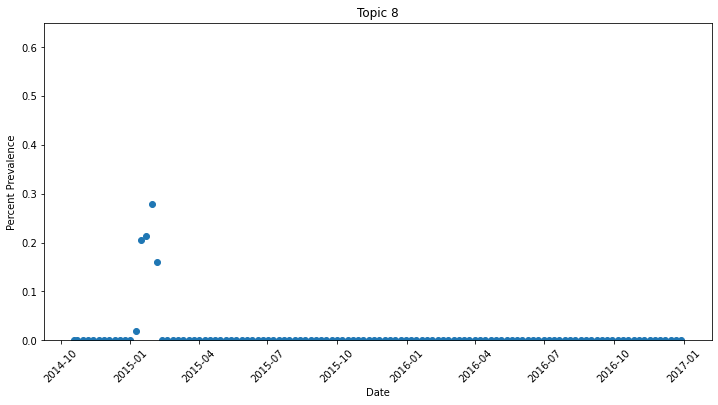

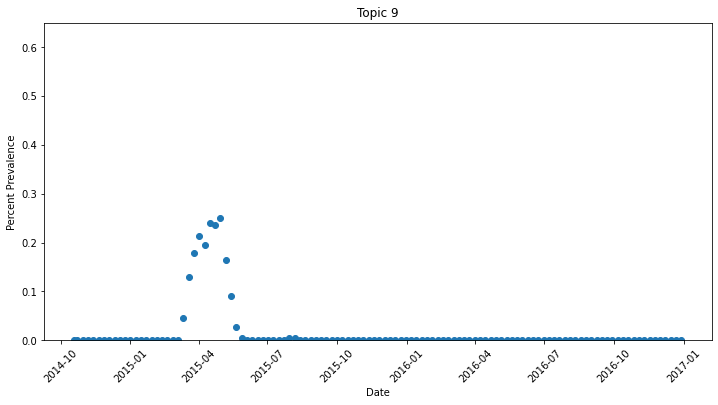

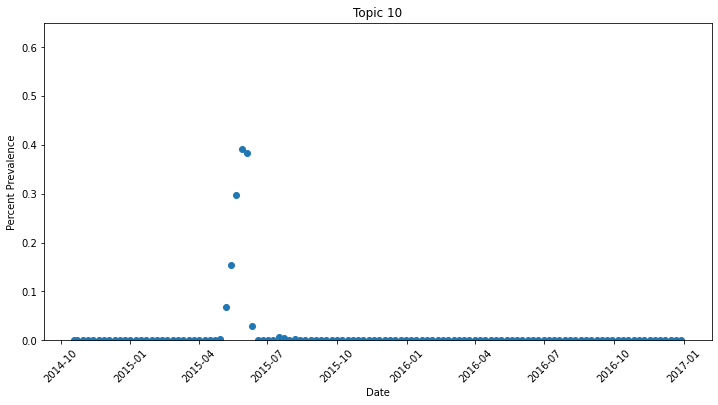

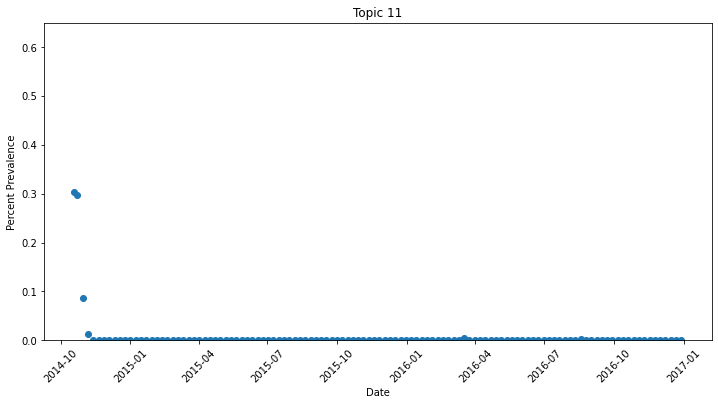

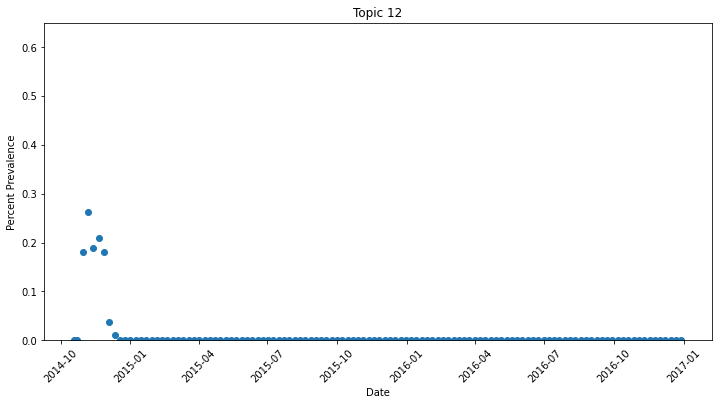

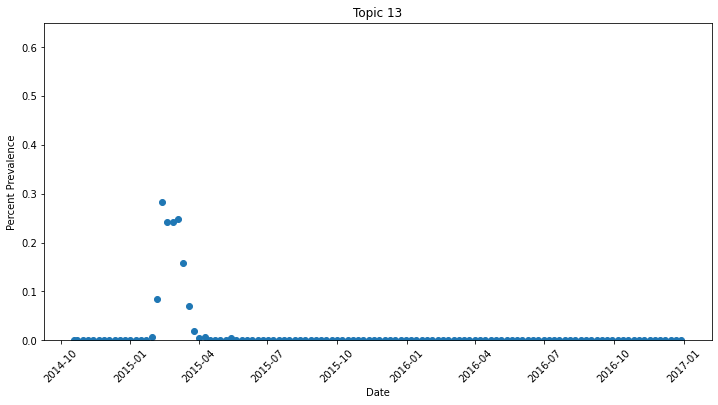

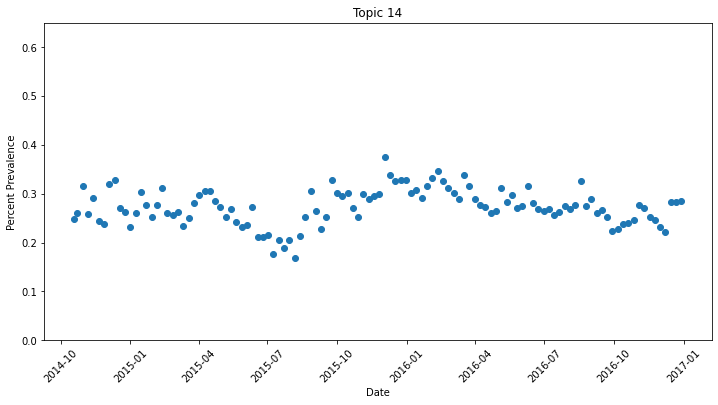

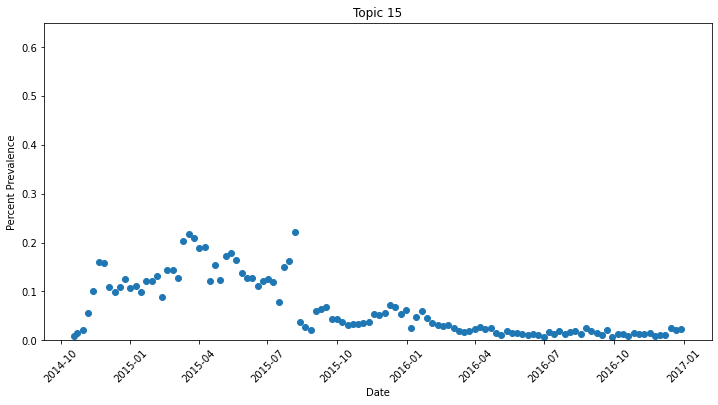

In [5]:
#generate topics
def graph_topics(data):
    for i in range(data.shape[1]):
        fig, axes = plt.subplots(1, 1, figsize=(10,5))
        fig.tight_layout(h_pad=5)
        axes.scatter(dates, data[:,i])
        axes.set_ylim([0,0.65])
        axes.tick_params(axis="x", rotation=45)
        axes.set_title(f"Topic {i}")
        axes.set_xlabel("Date")
        axes.set_ylabel("Percent Prevalence")
        fig.savefig(f"{output_folder}/topics/topic-{i}.png")

graph_topics(topics)

In [6]:
# This function allows us to efficiently iterate over the state file.
# Note: This file is huge and should not be read into memory all at once.
def iterate_state():
    """Iterate over lines in state"""
    with gzip.open(f"{input_folder}/topic-state.gz", "r") as f:
        # The state file has a three line header that we are skipping.
        f.readline()
        f.readline()
        f.readline()

        for entry in f:
            yield entry.decode().split()

In [7]:
# Let's generate example strings. These are strings of words that are all the same topic.
def example(length):
    data = {}

    current_doc = []
    current_index = []
    for doc, source, pos, typeindex, type_, topic in iterate_state():
        if type_ == "newline":
            if len(set(current_index)) == 1:
                if len(current_doc) >= length:
                    if current_index[0] not in data:
                        data[current_index[0]] = []
                    data[current_index[0]].append(" ".join(current_doc))

            current_index = []
            current_doc = []
            continue

        current_doc.append(type_)
        current_index.append(topic)

    return data

for key, items in example(5).items():
    with open(f"{output_folder}/examples/topic-{key}.txt", "w+") as g:
        for line in items:
            print(line, file=g)

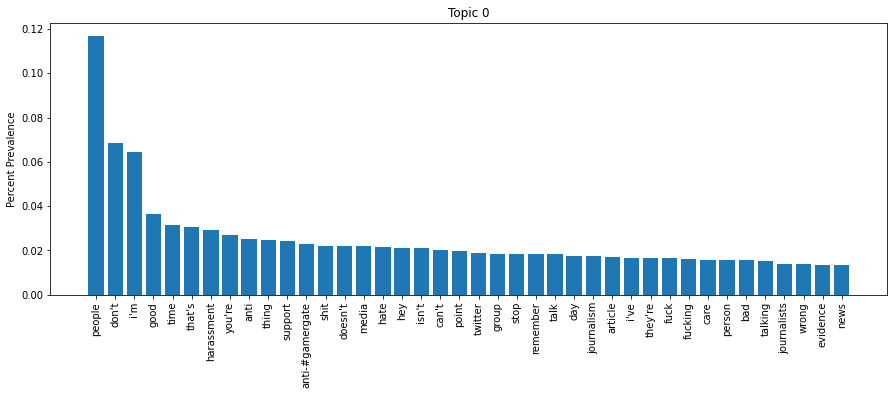

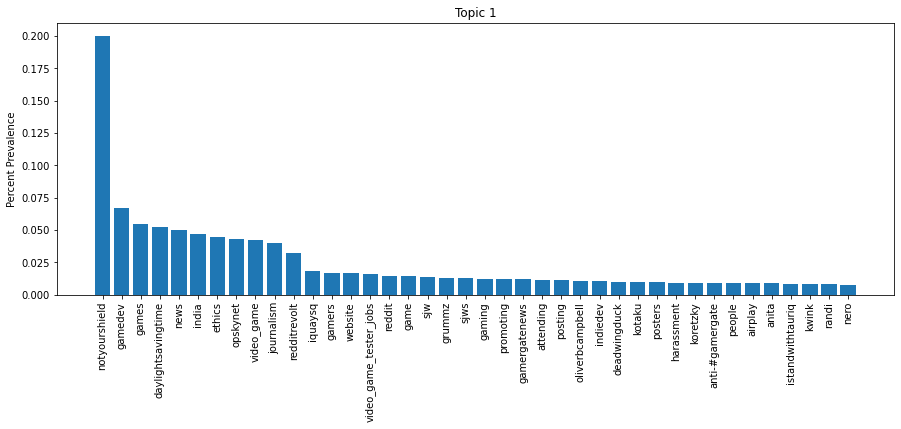

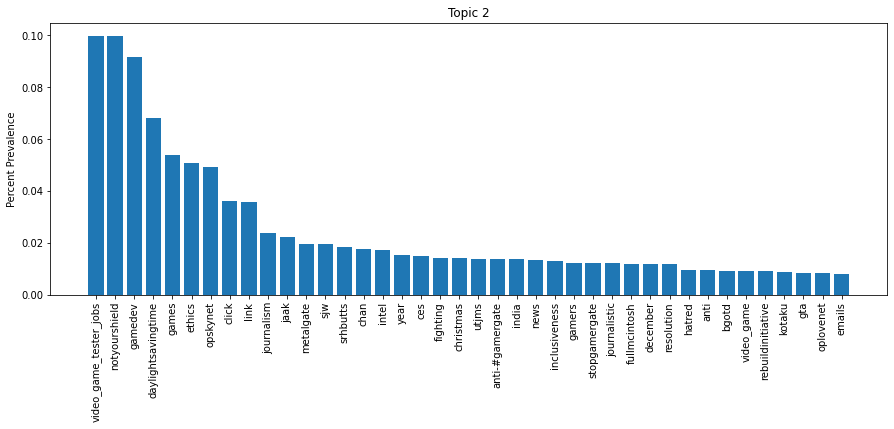

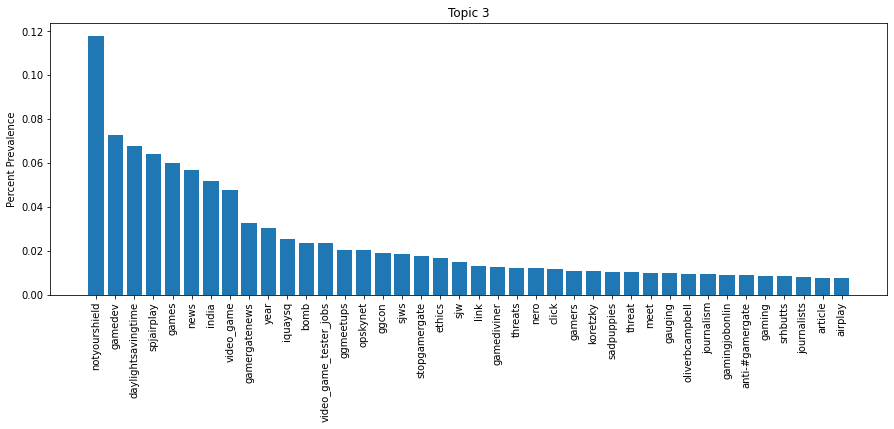

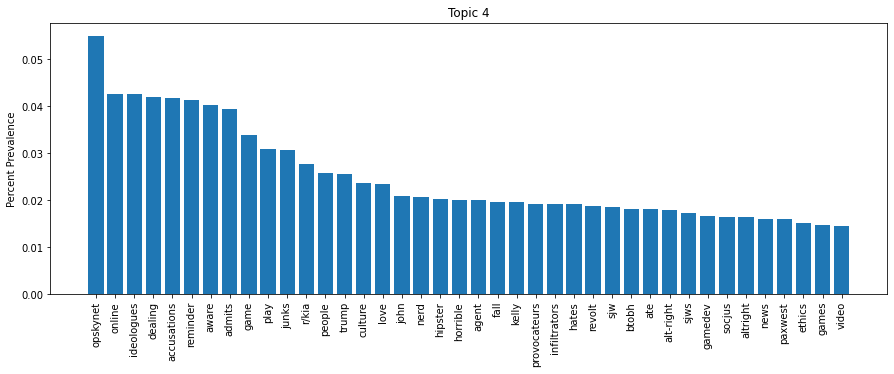

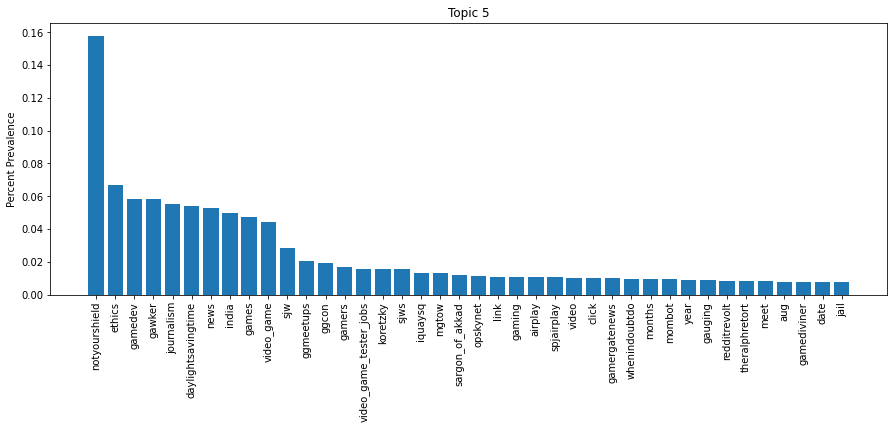

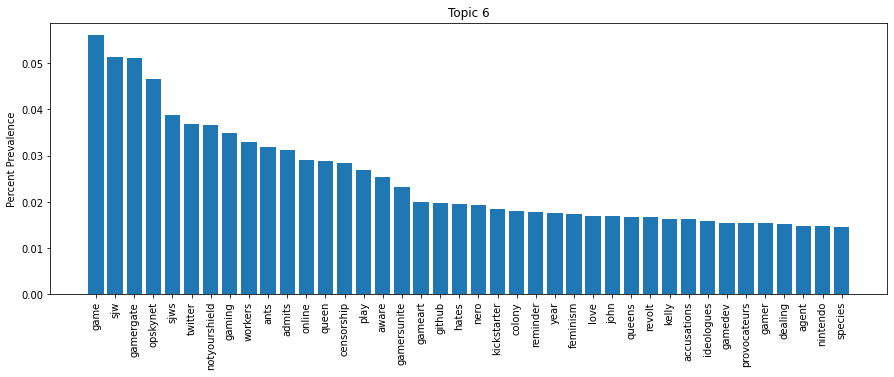

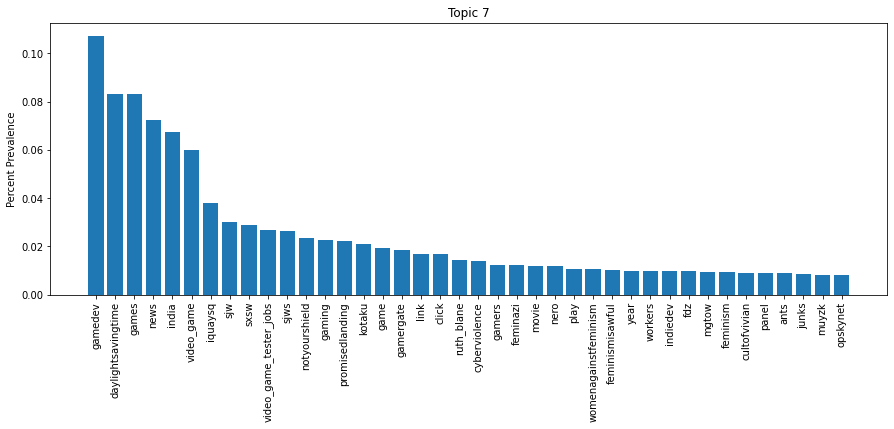

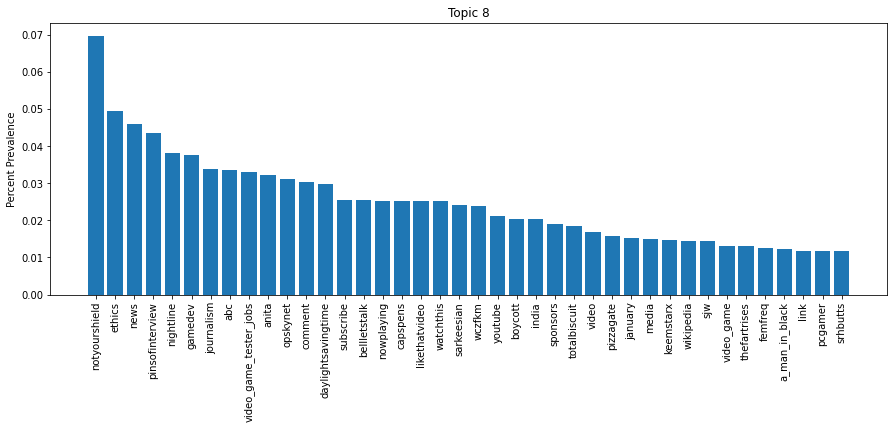

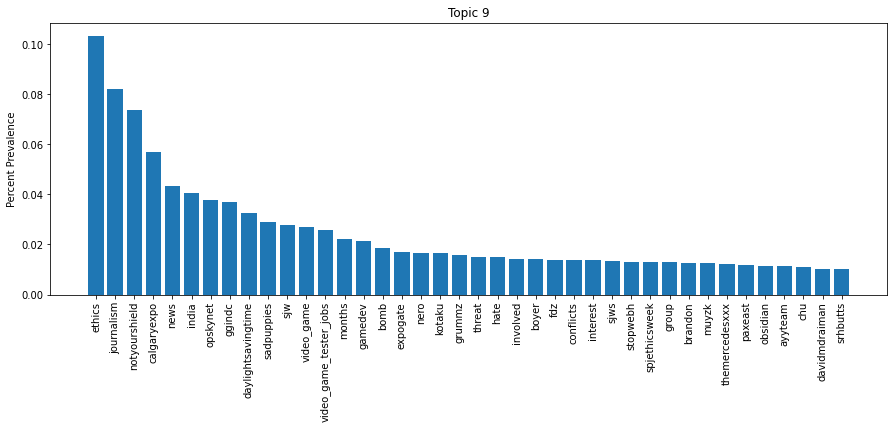

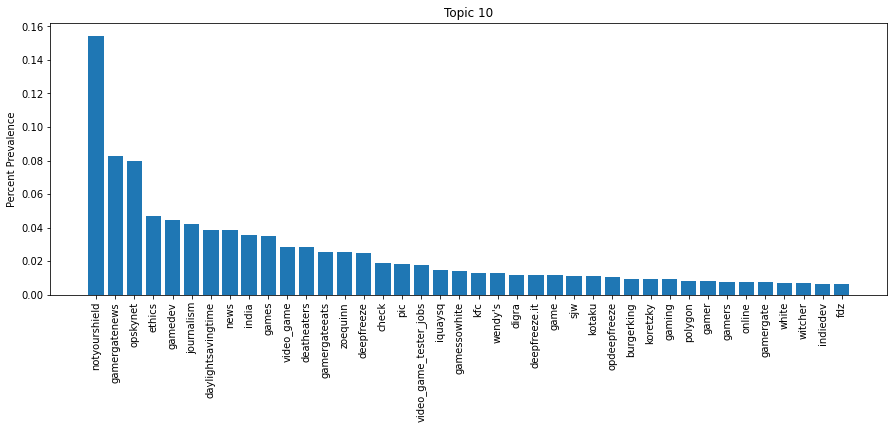

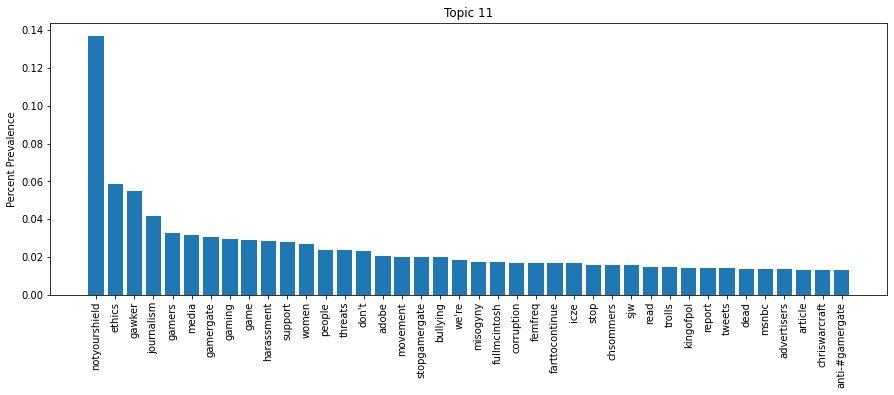

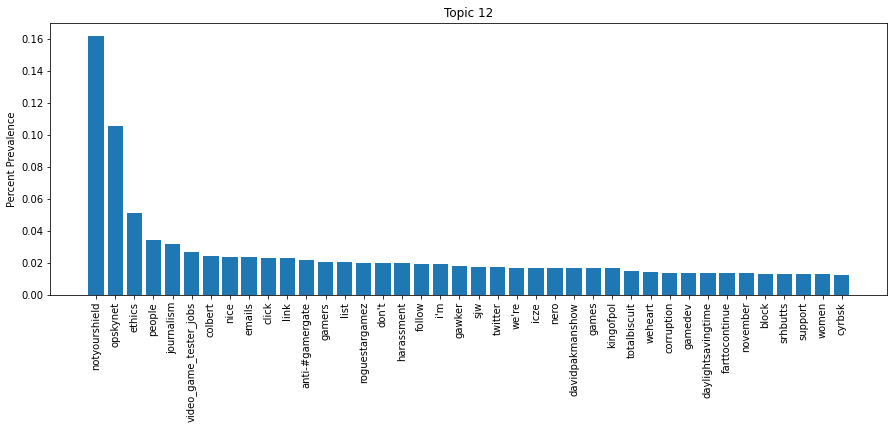

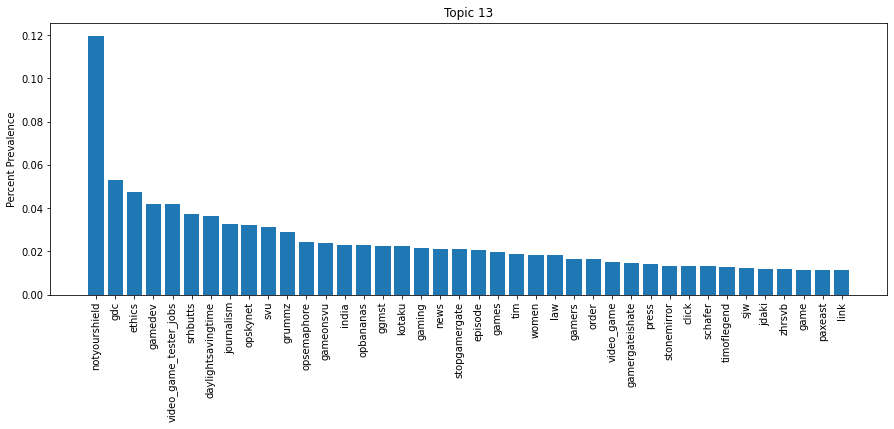

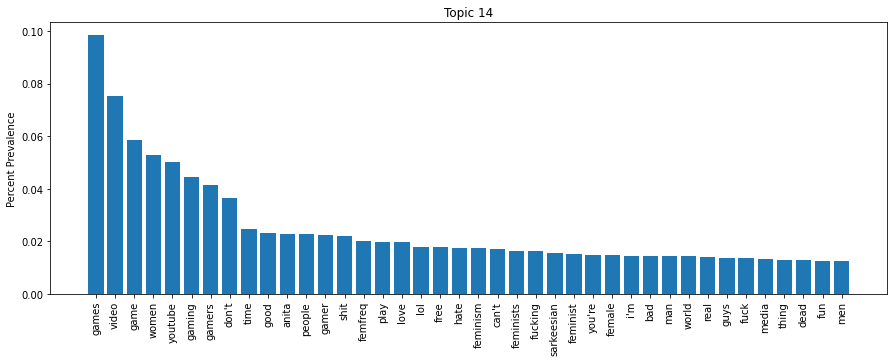

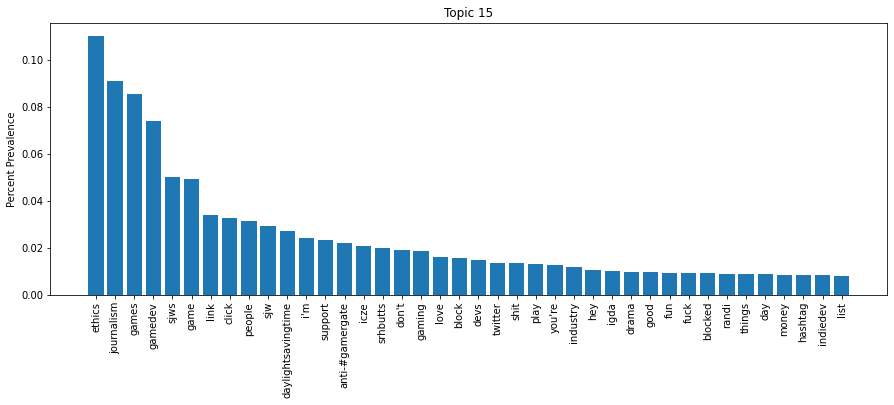

In [8]:
# Generate all topic keyword graphs.
def get_word_frequencies():
    data = {}
    for i in range(16):
        data[i] = Counter()

    for doc, source, pos, typeindex, type_, topic in iterate_state():
        data[int(topic)][type_] +=1

    return data

all_words = get_word_frequencies()
stopwords = {"newline"}

def create_token_hist(name, data_raw, num_keys):
    data = copy.copy(data_raw)

    keys = sorted(data.keys(), key=lambda x: data[x], reverse=True)
    keys = [i for i in keys if i not in stopwords]
    keys = [i for i in keys if "http://" not in i and "https://" not in i]
    keys = keys[:num_keys]

    total = sum(data[i] for i in keys)

    fig, axes = plt.subplots(1, 1, figsize=(15,5))
    axes.bar(keys, [data[i] / total for i in keys])
    axes.tick_params(axis="x", labelrotation=90)
    axes.set_title(f"Topic {name}")
    axes.set_ylabel("Keyword")
    axes.set_ylabel("Percent Prevalence")
    fig.savefig(f"{output_folder}/keys/topic-{name}.png")

for j in range(16):
    create_token_hist(j, all_words[j], 40)


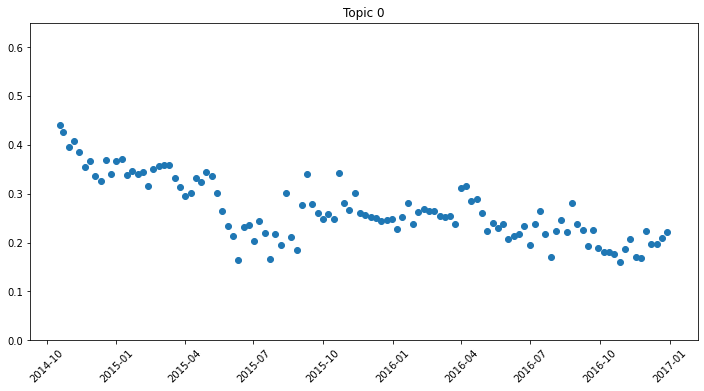

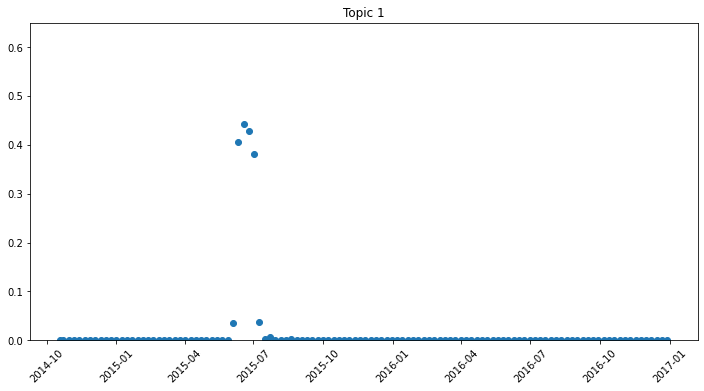

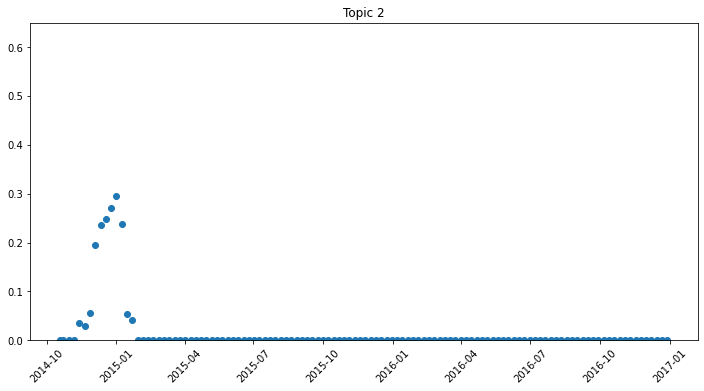

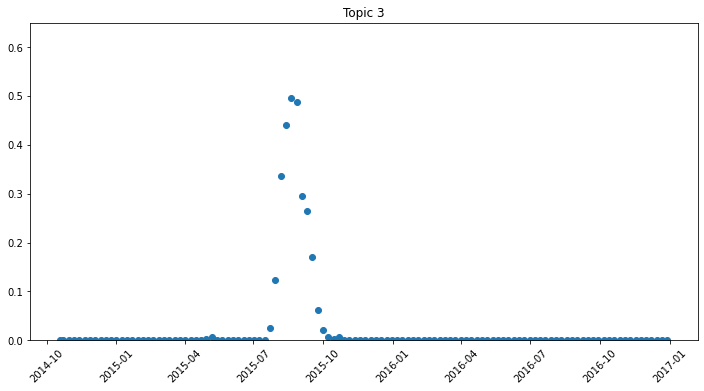

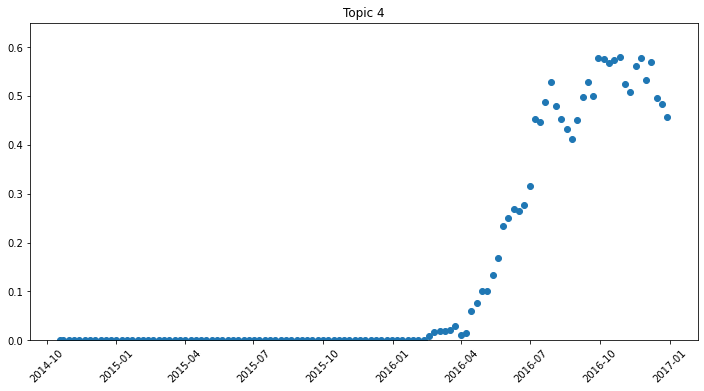

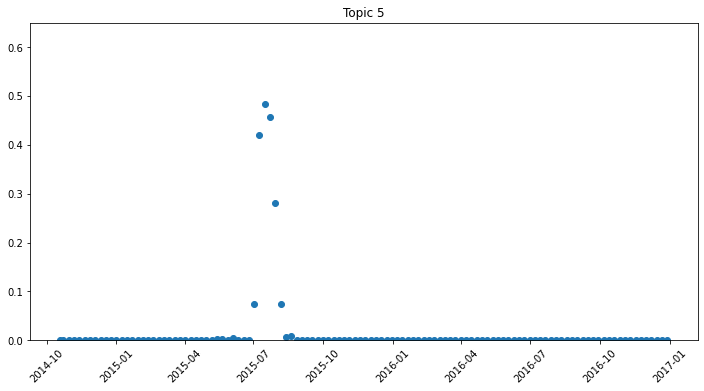

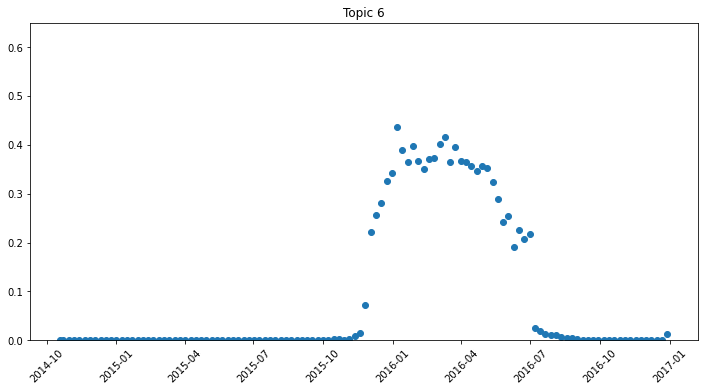

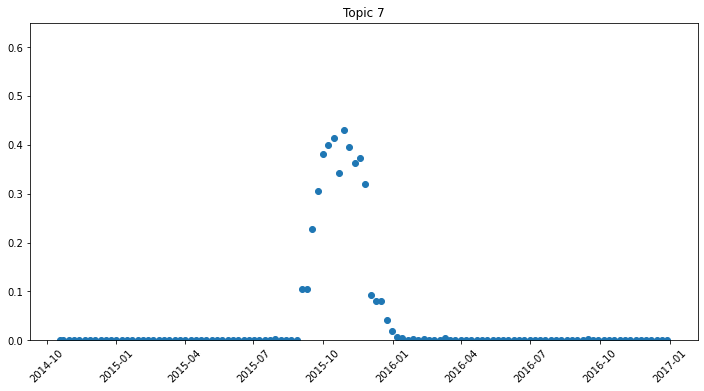

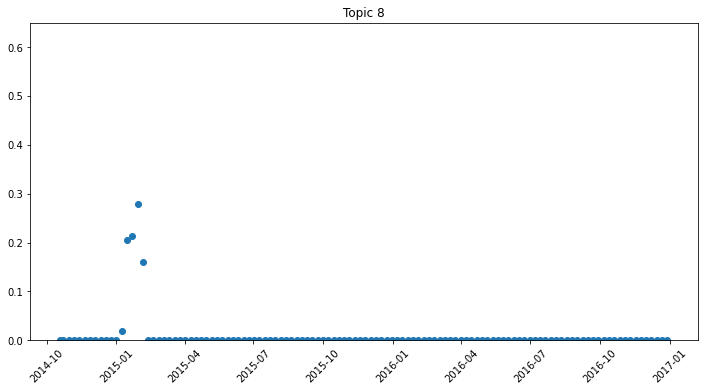

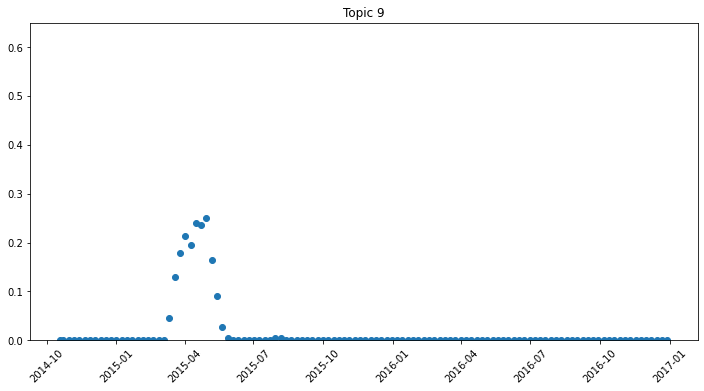

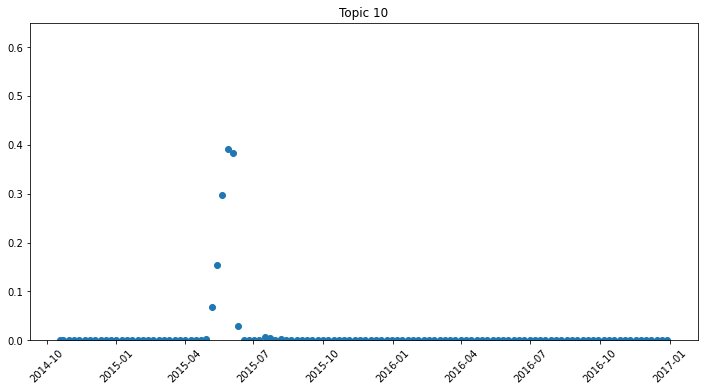

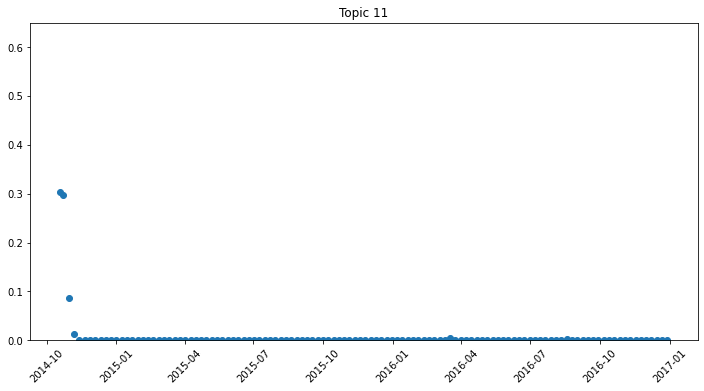

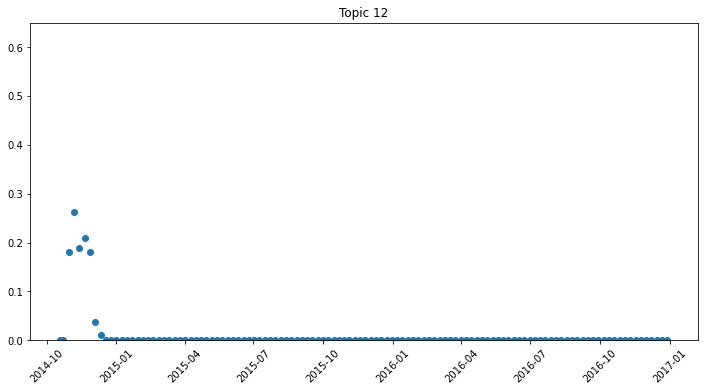

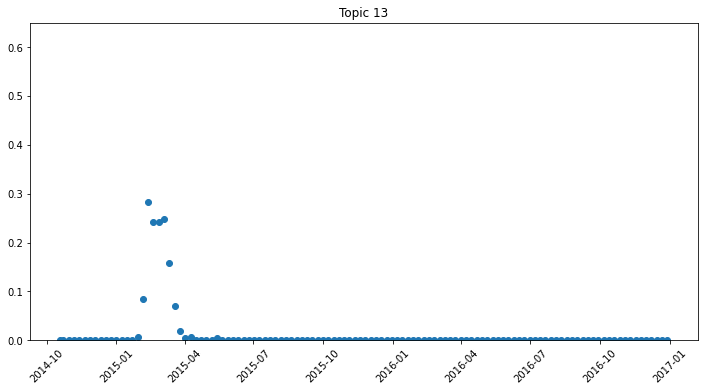

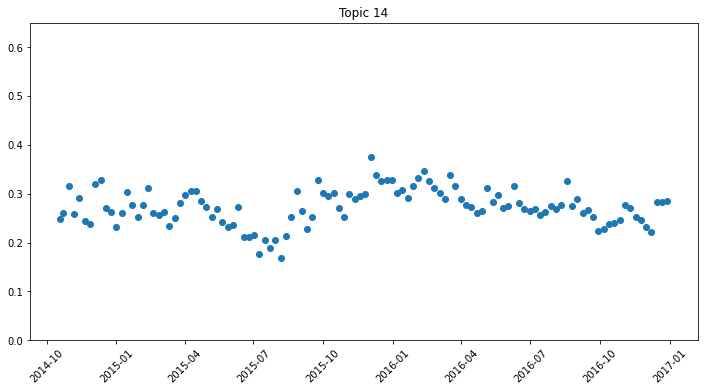

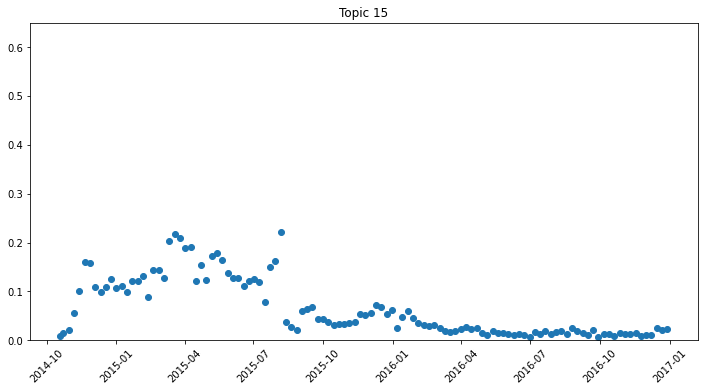

In [9]:
# Graph all documents by topic
#generate topics
def graph_topics(data):
    for i in range(data.shape[1]):
        fig, axes = plt.subplots(1, 1, figsize=(10,5))
        fig.tight_layout(h_pad=5)
        axes.scatter(dates, data[:,i])
        axes.set_ylim([0,0.65])
        axes.tick_params(axis="x", rotation=45)
        axes.set_title(f"Topic {i}")
        fig.savefig(f"{output_folder}/topics/topic-{i}.png")

graph_topics(topics)

<ipython-input-11-422cc77573d8>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 1, figsize=(10,5))


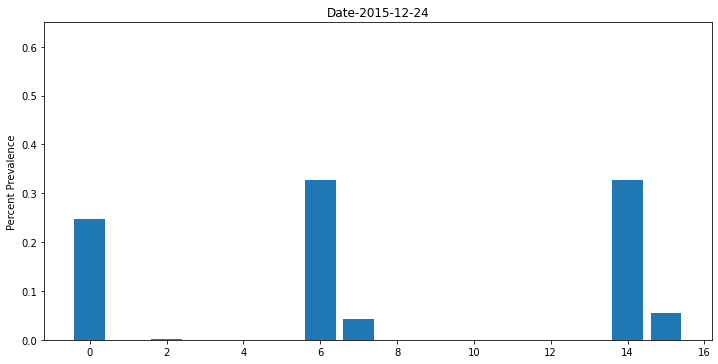

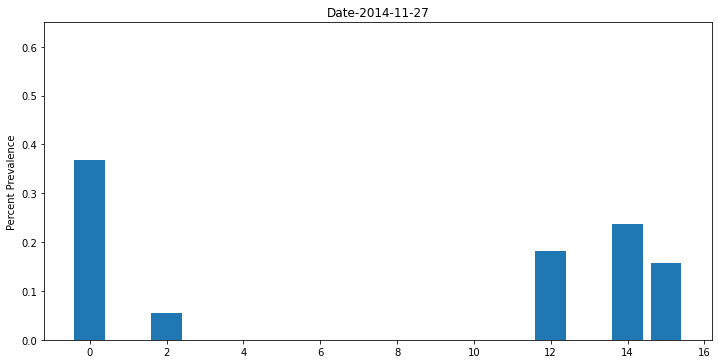

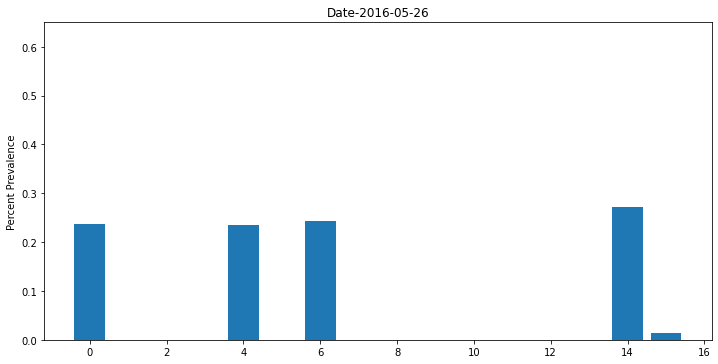

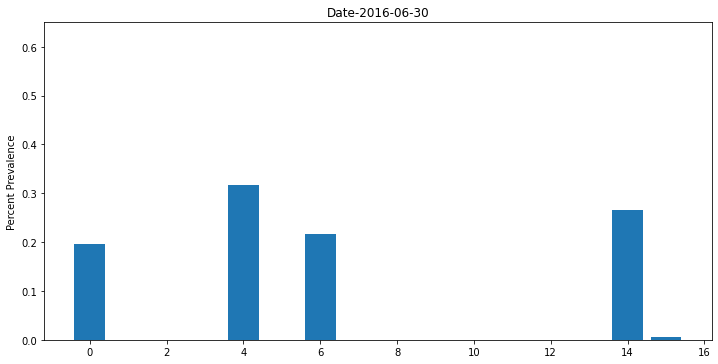

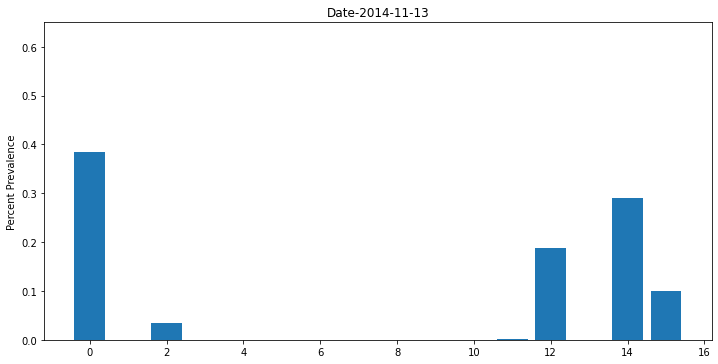

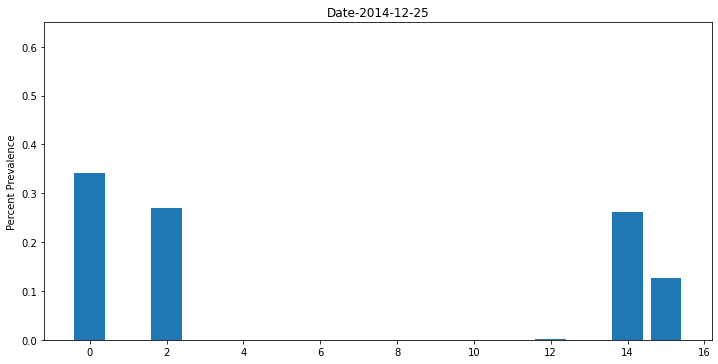

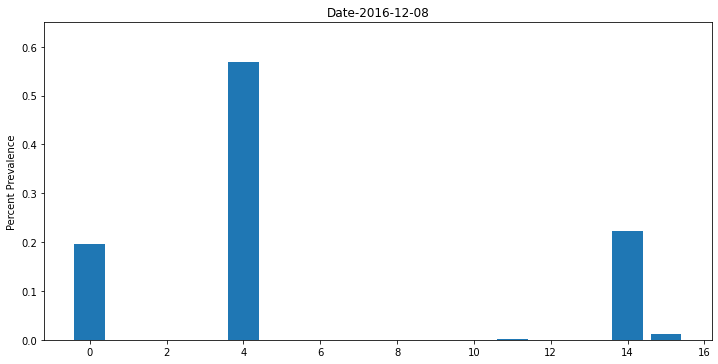

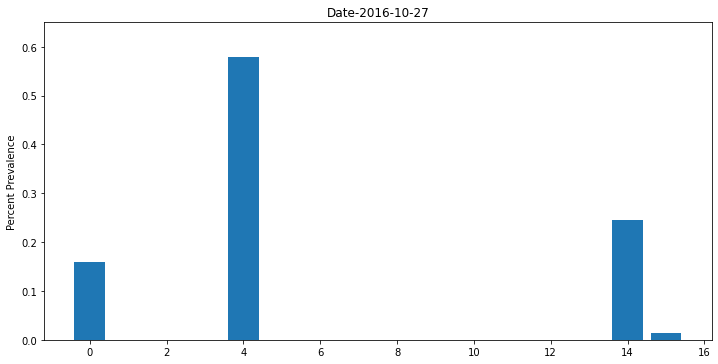

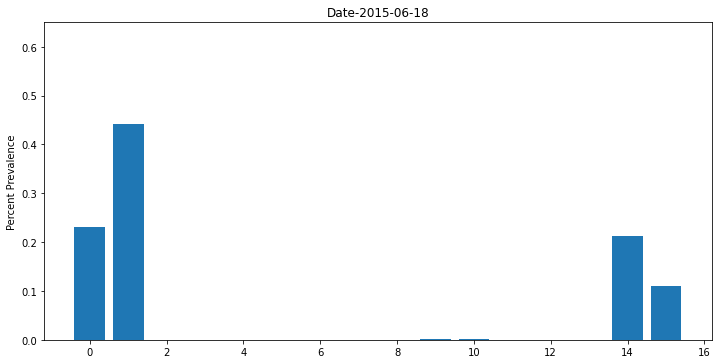

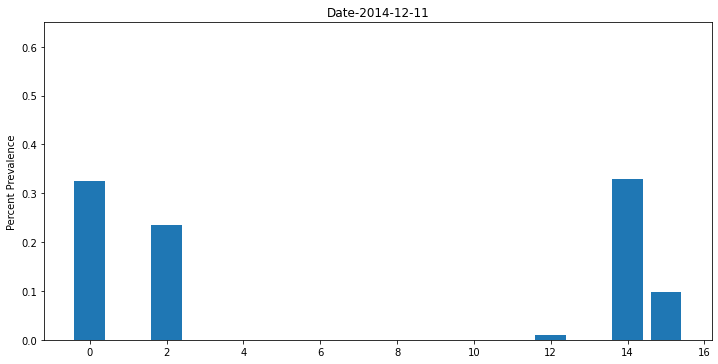

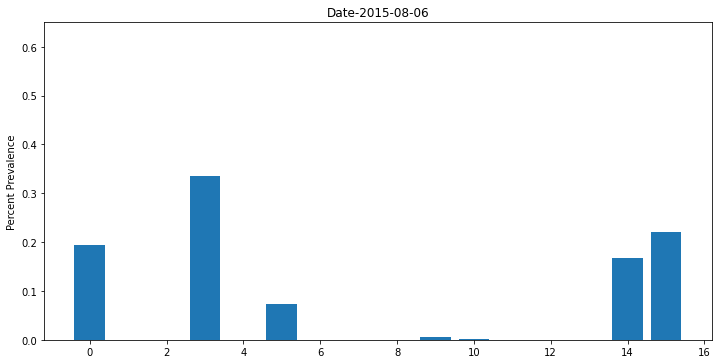

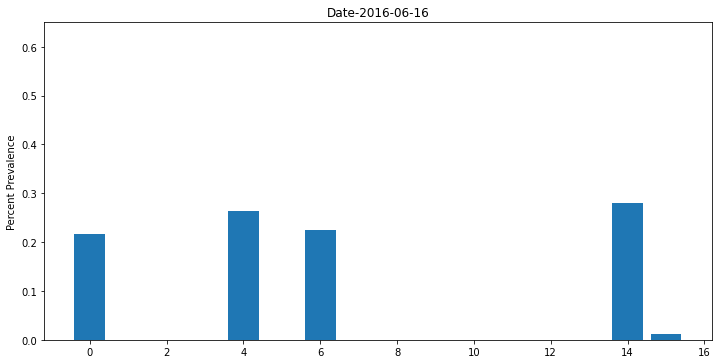

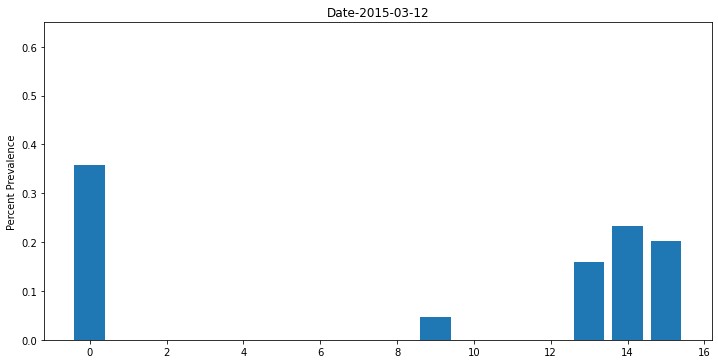

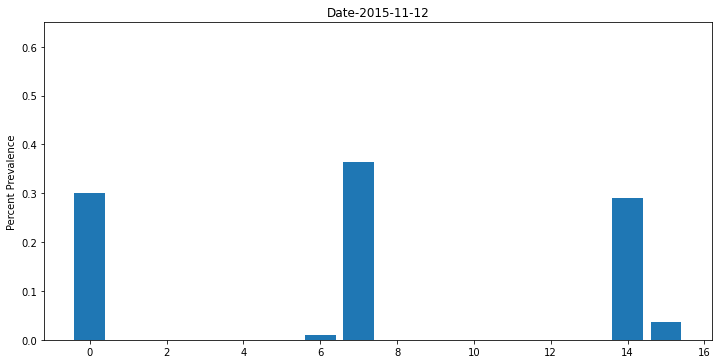

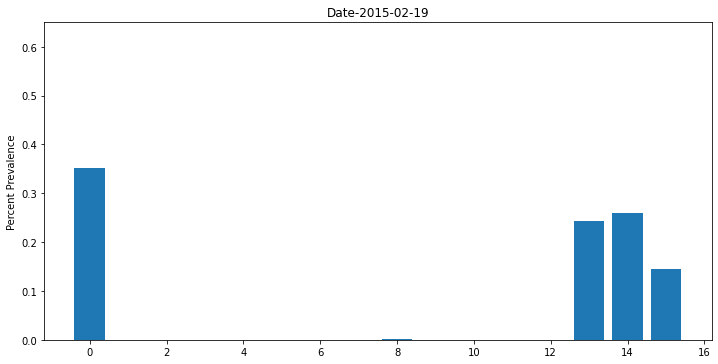

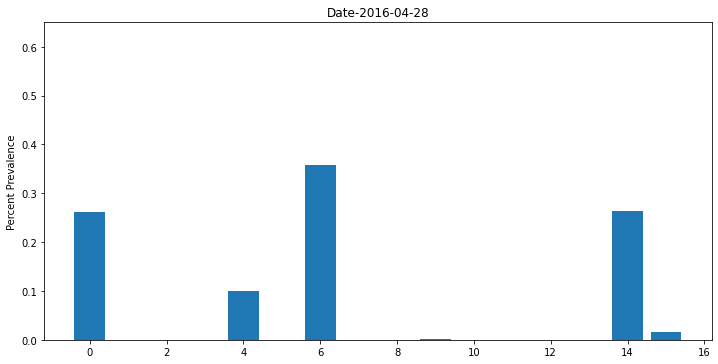

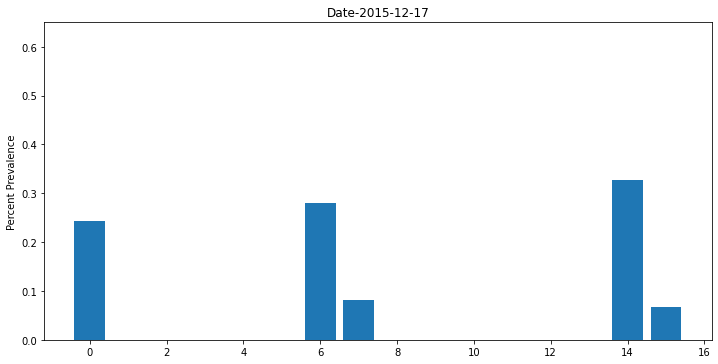

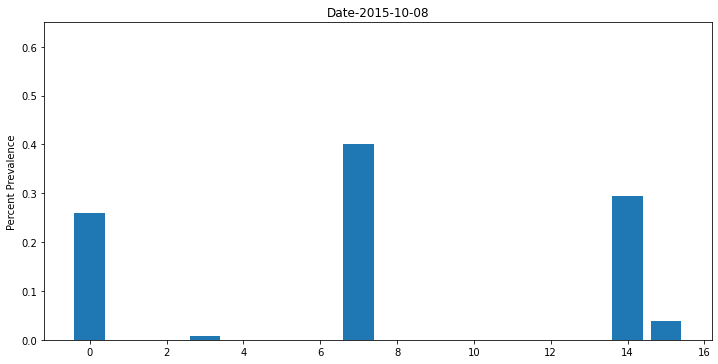

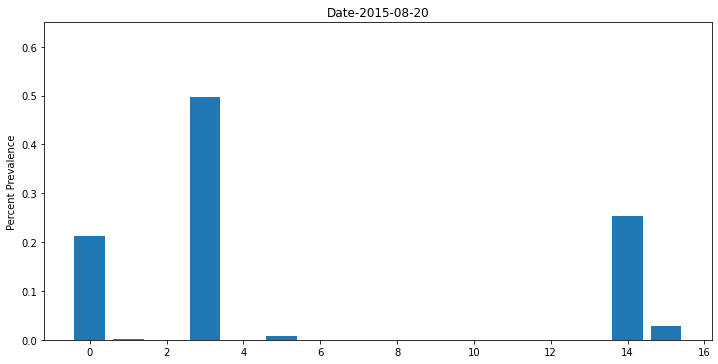

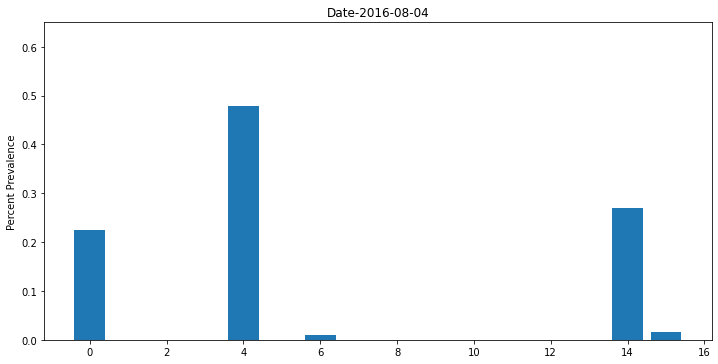

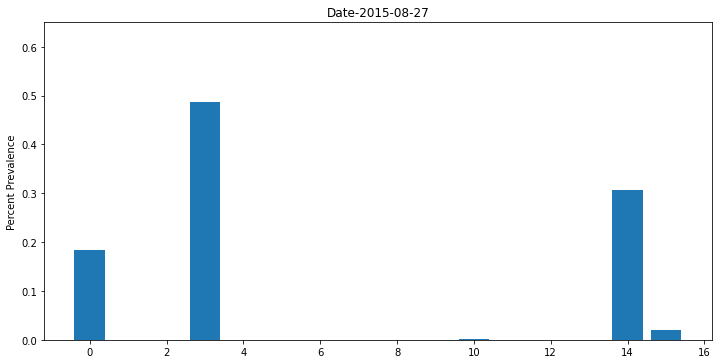

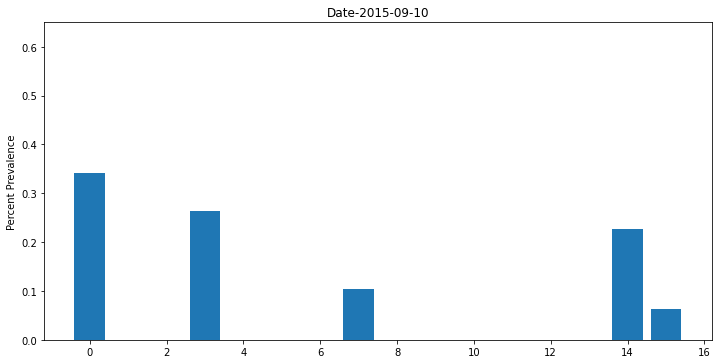

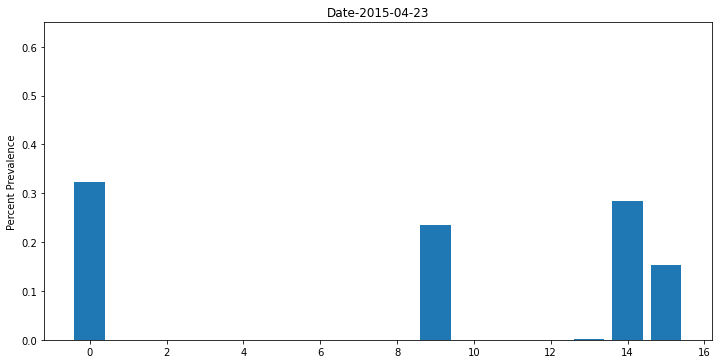

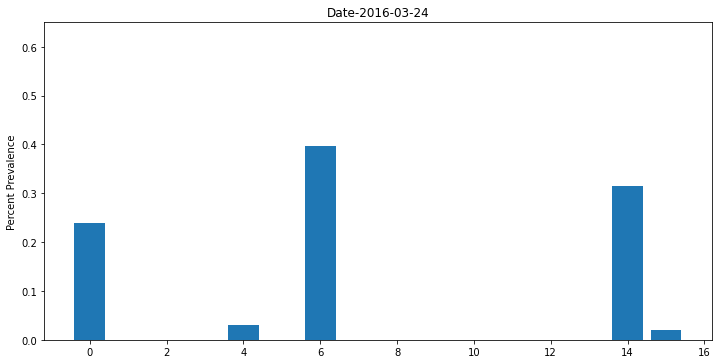

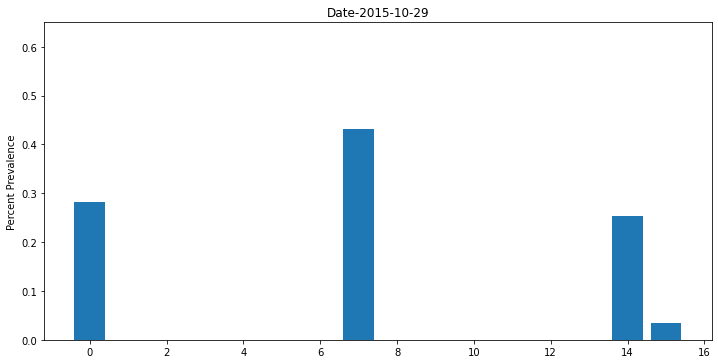

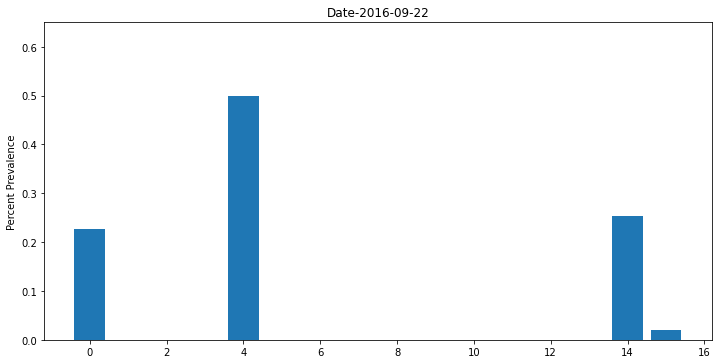

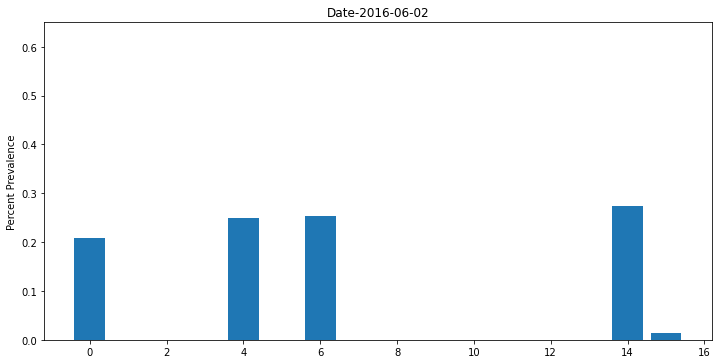

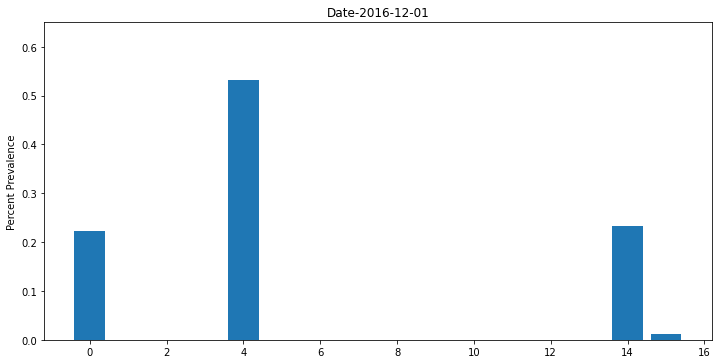

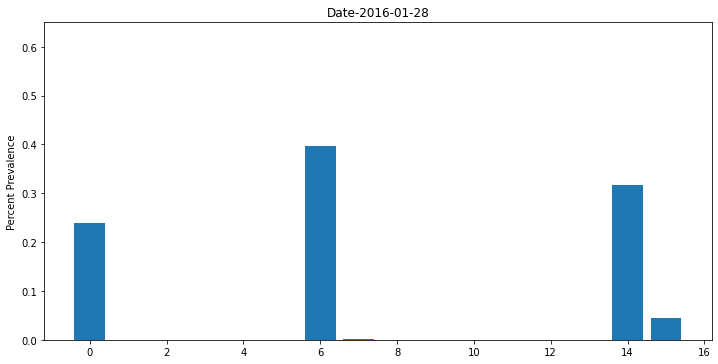

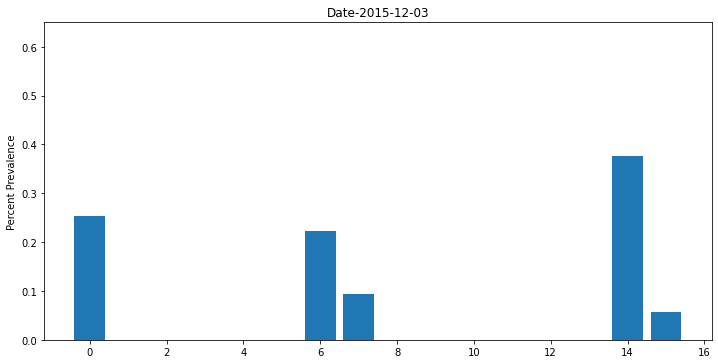

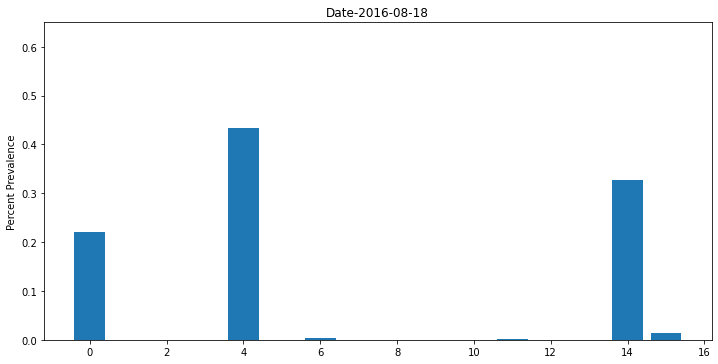

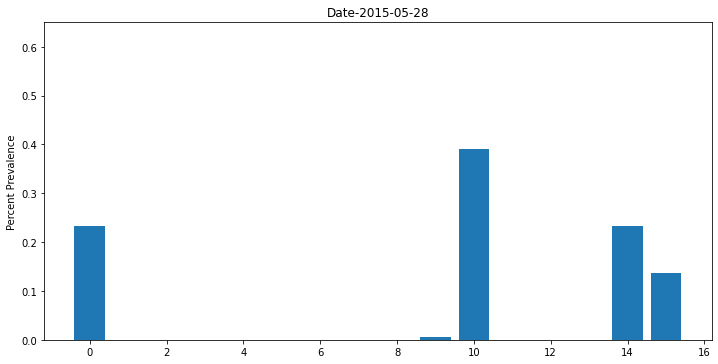

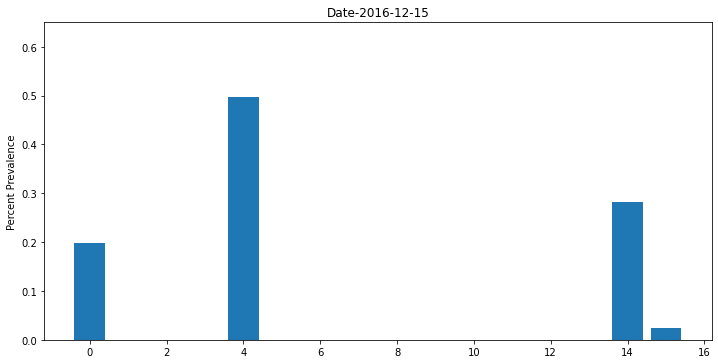

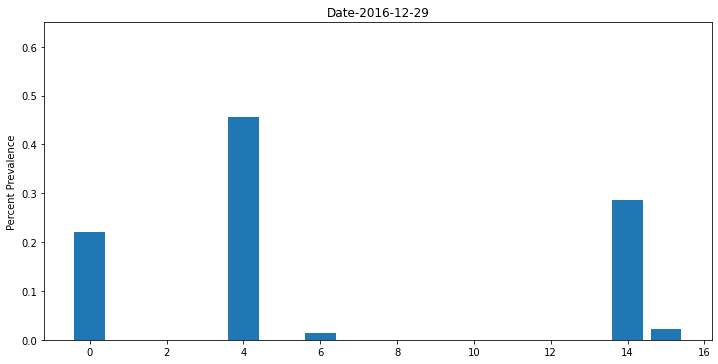

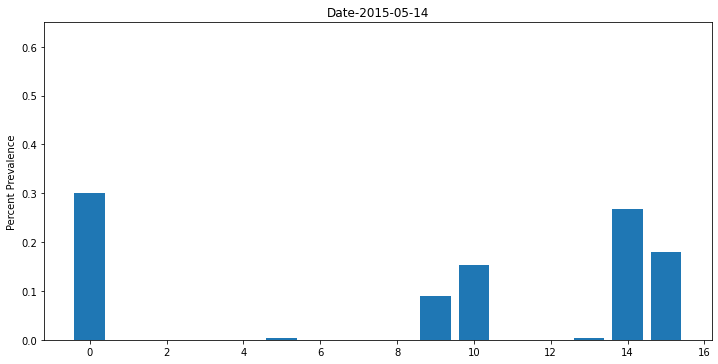

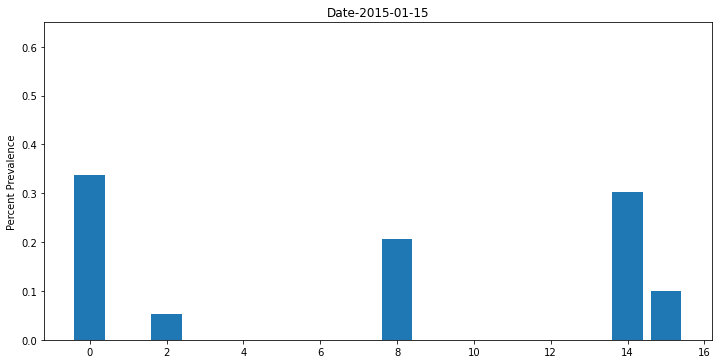

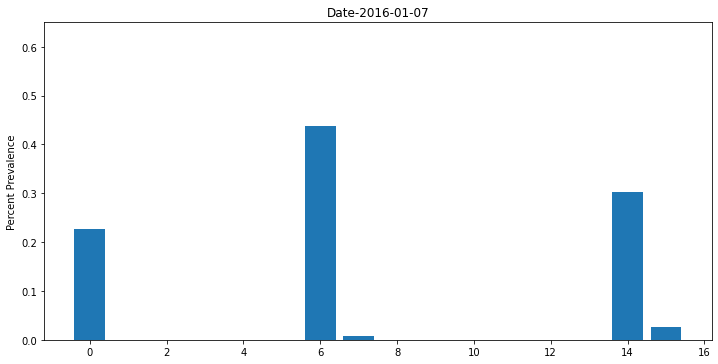

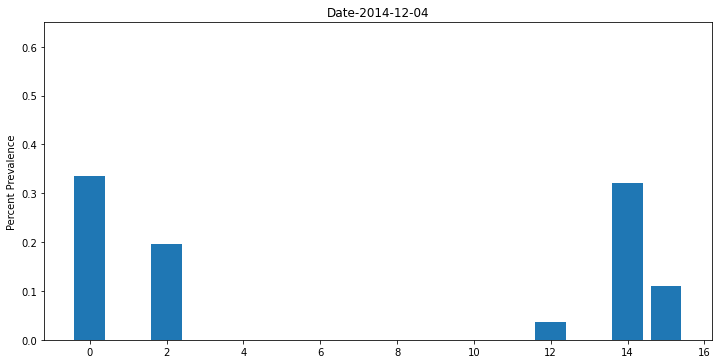

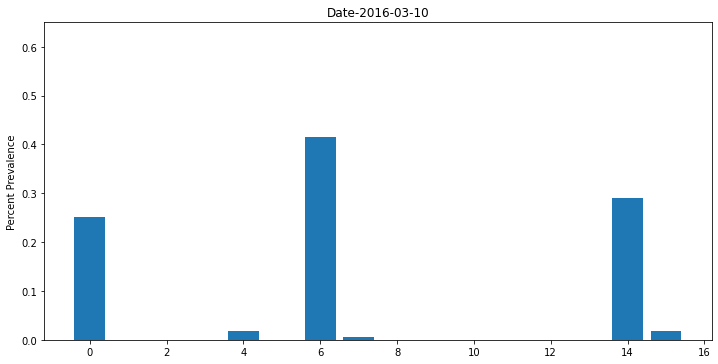

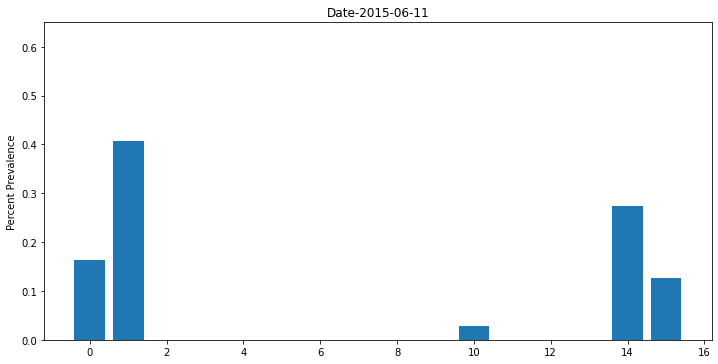

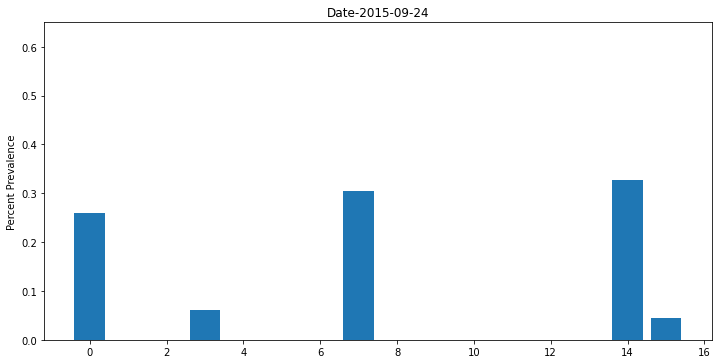

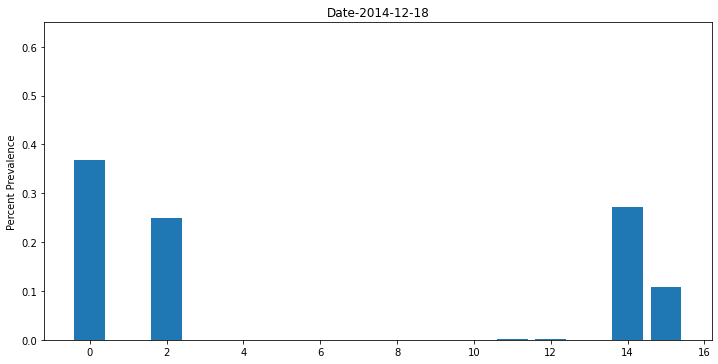

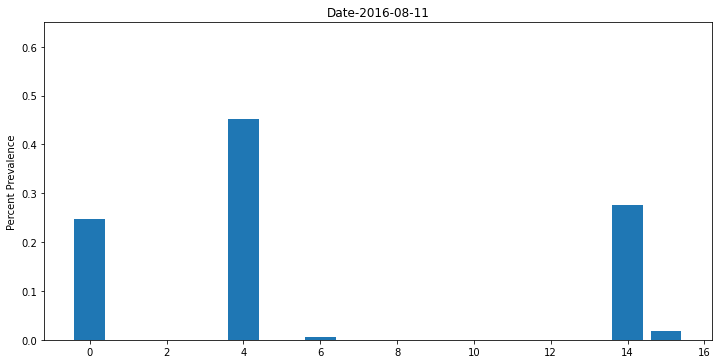

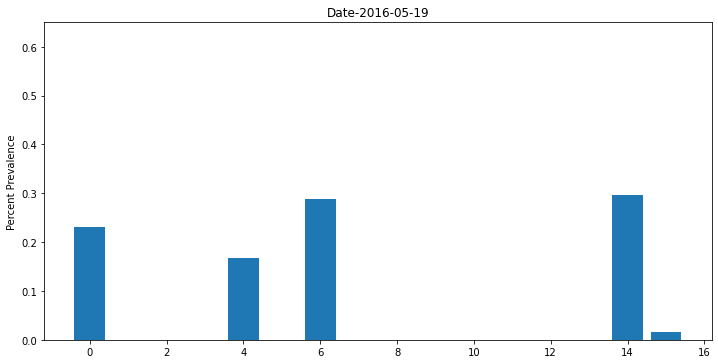

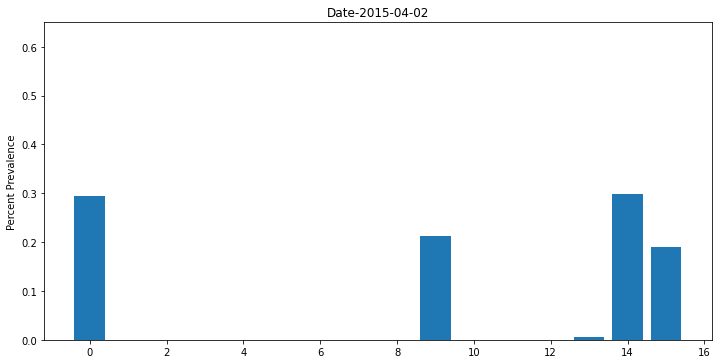

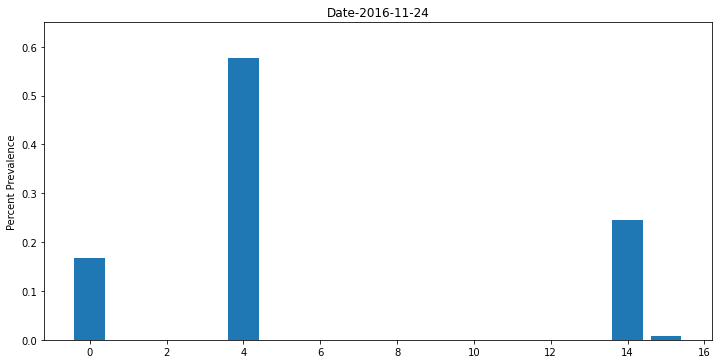

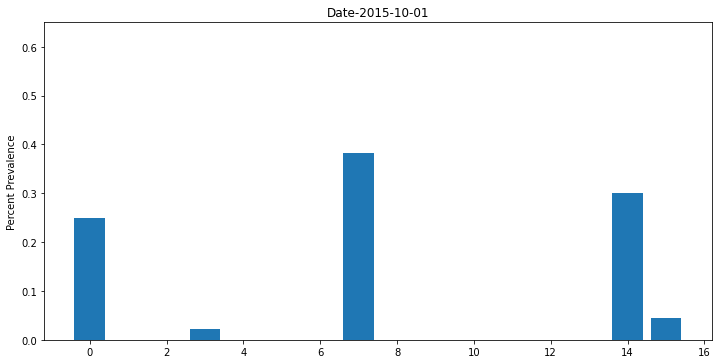

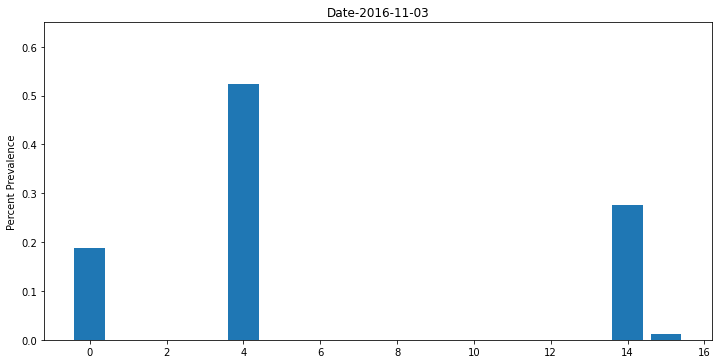

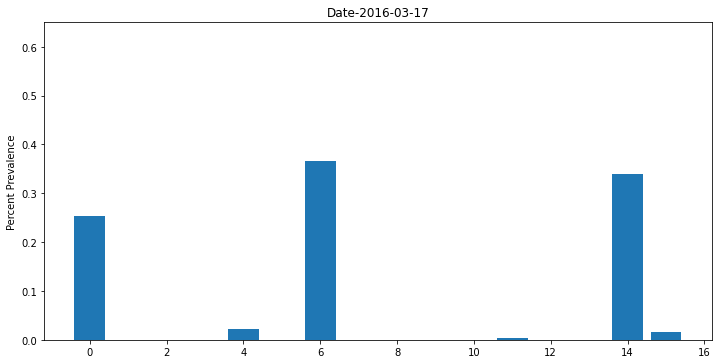

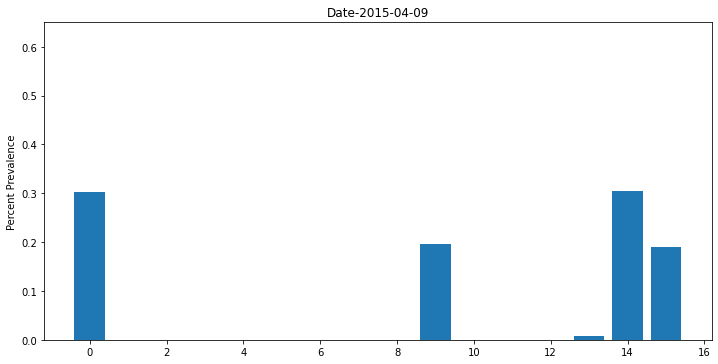

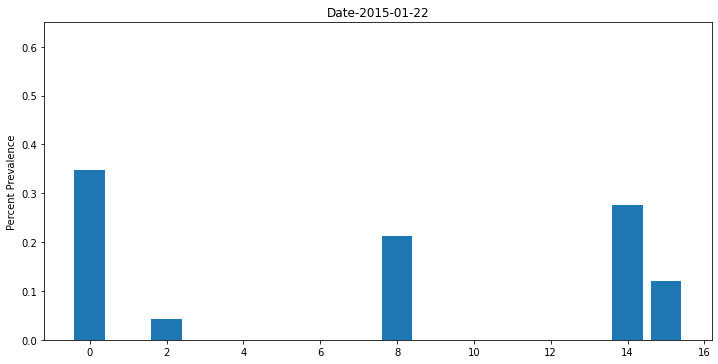

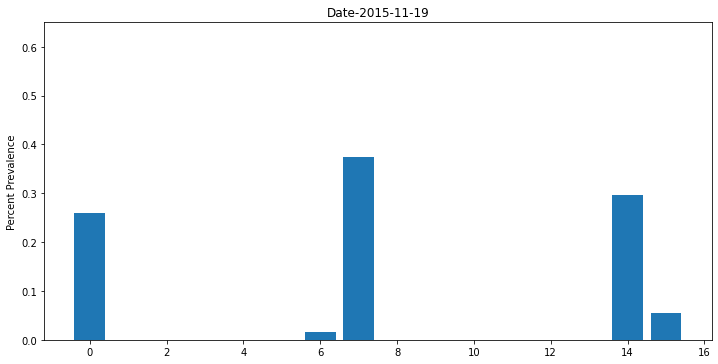

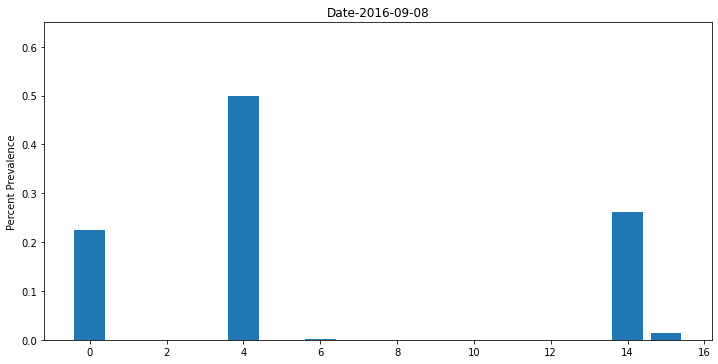

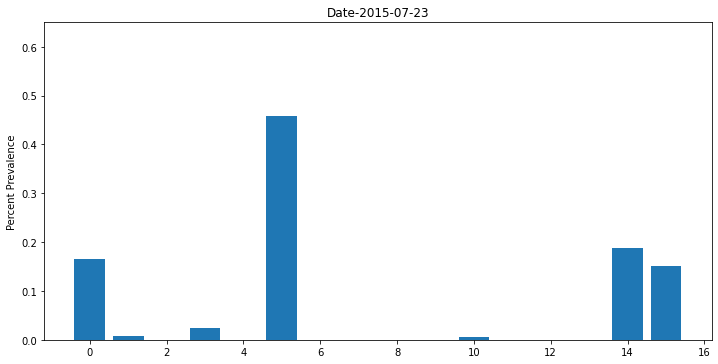

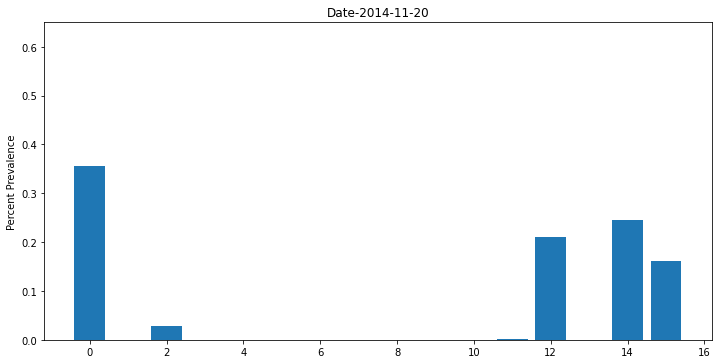

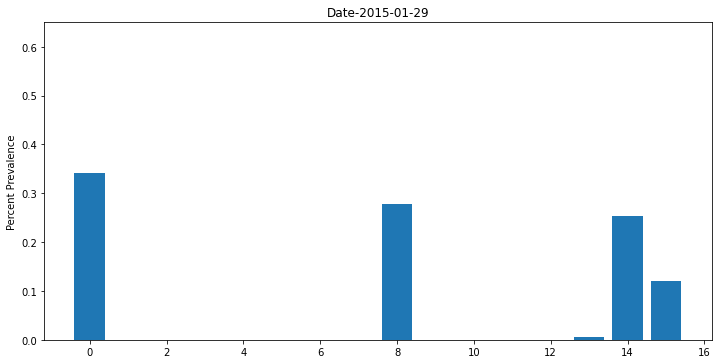

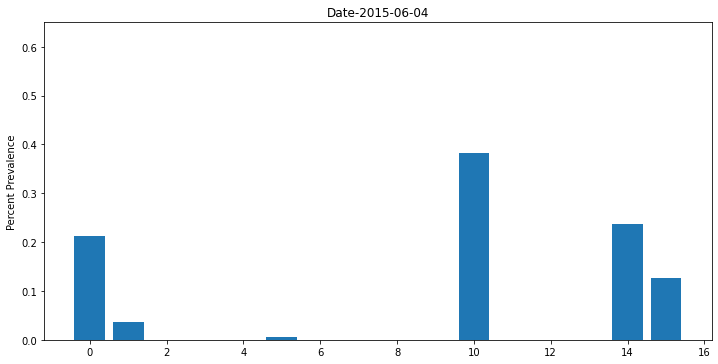

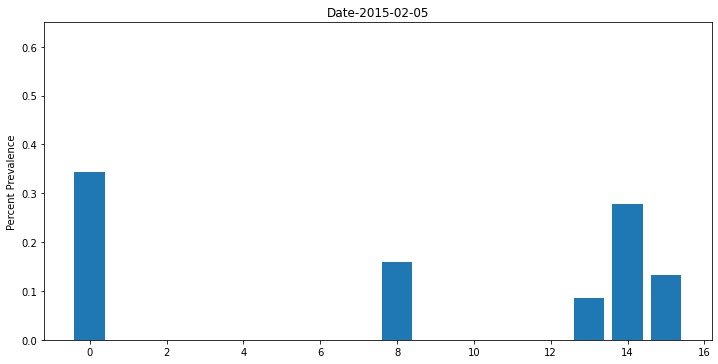

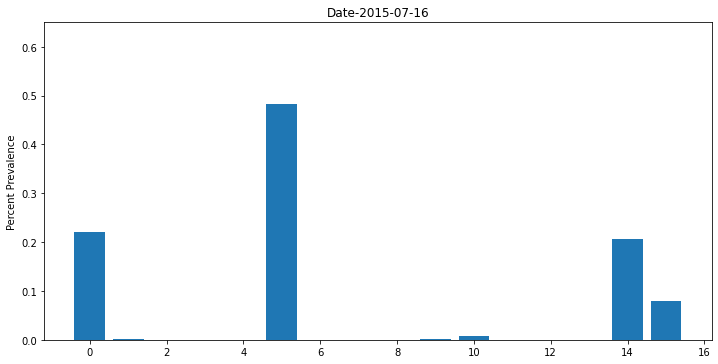

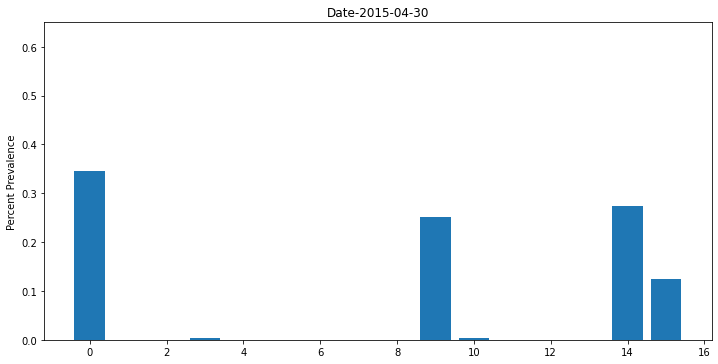

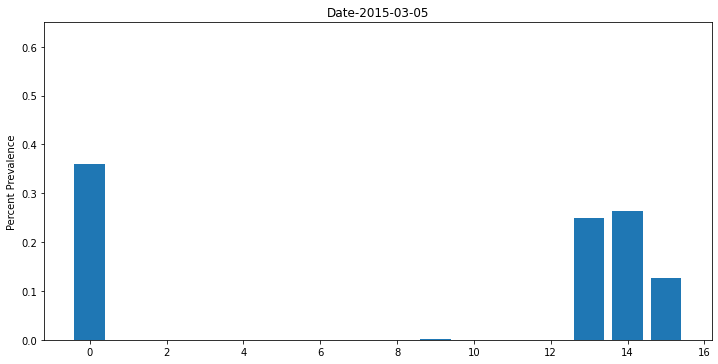

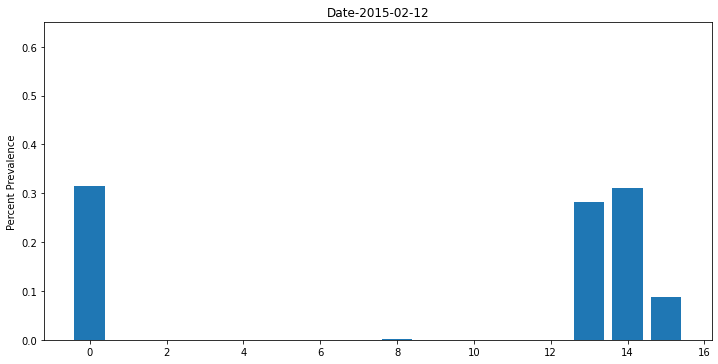

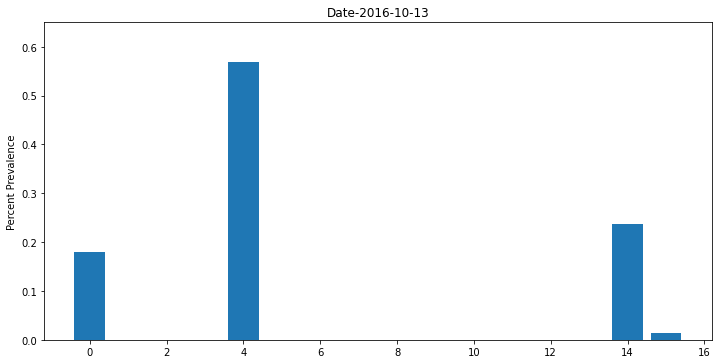

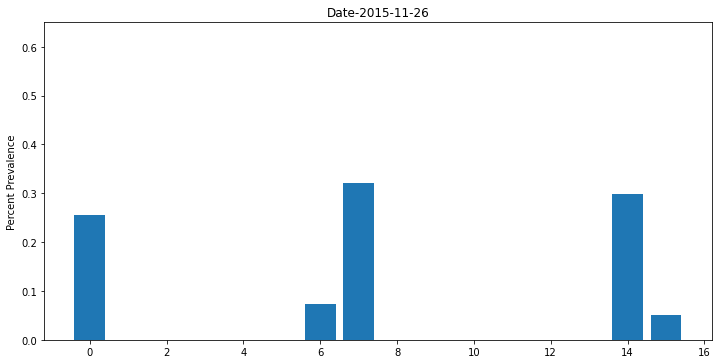

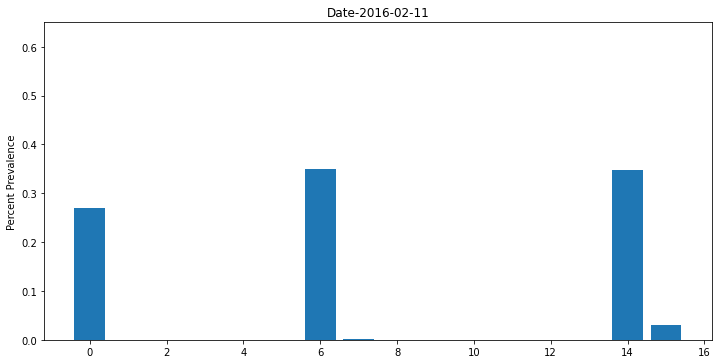

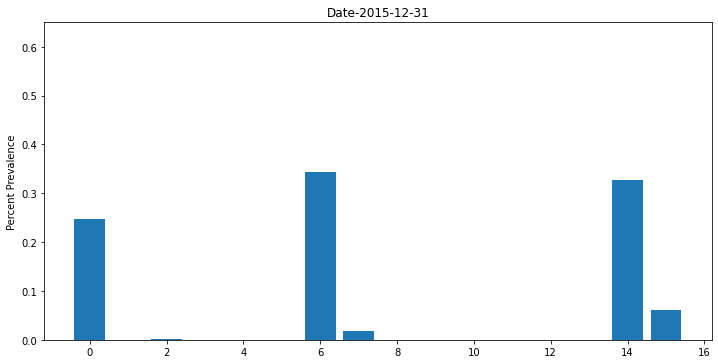

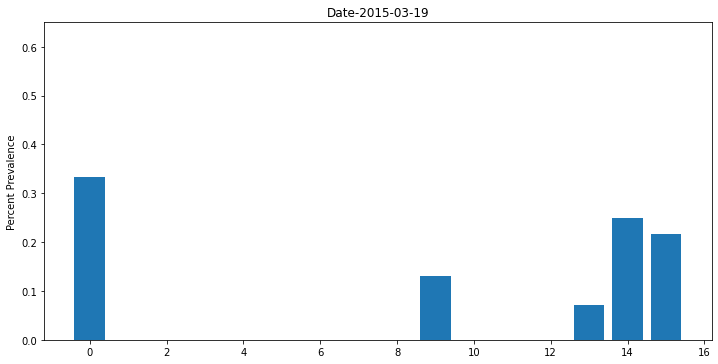

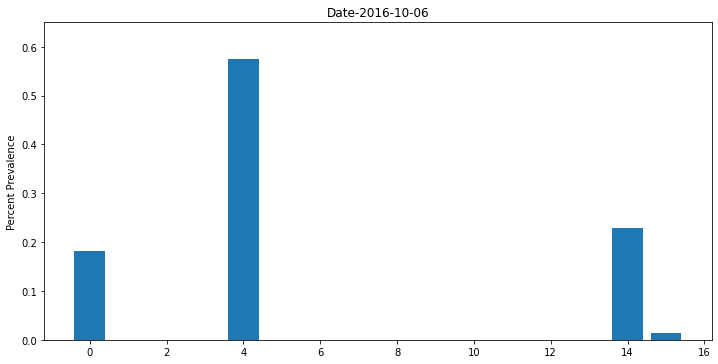

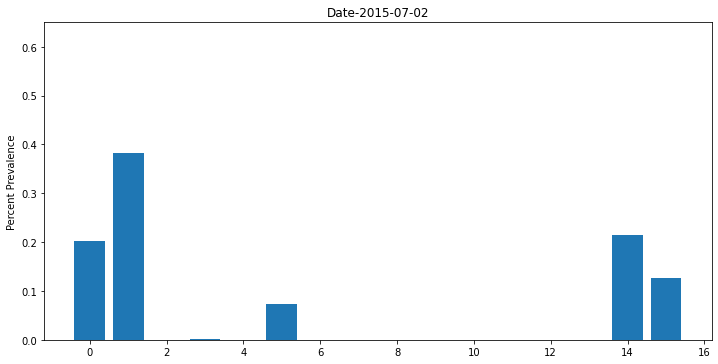

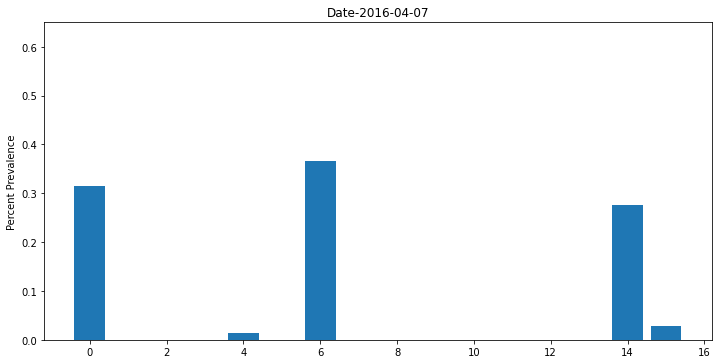

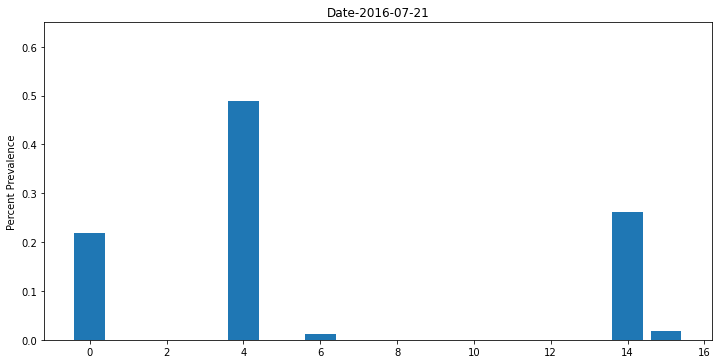

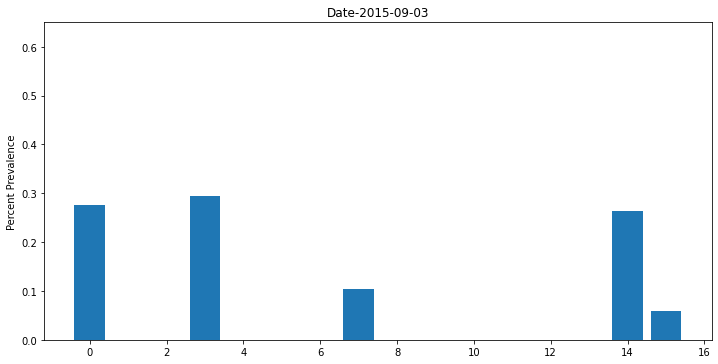

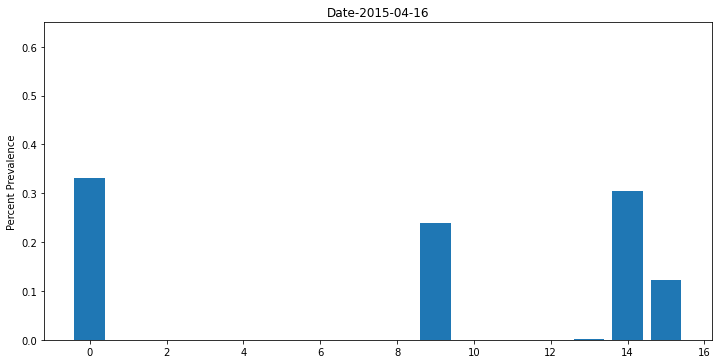

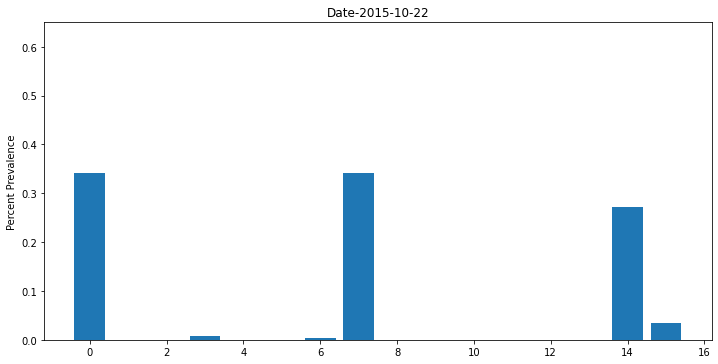

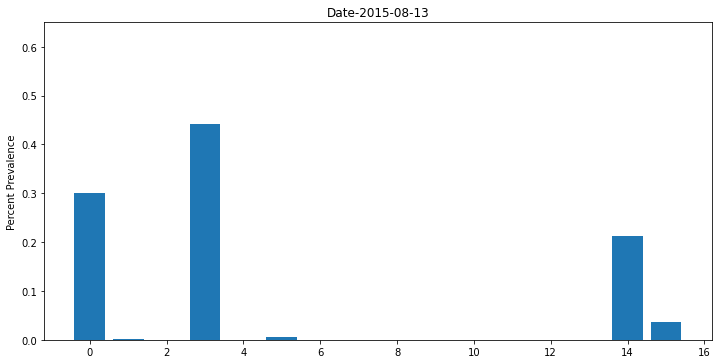

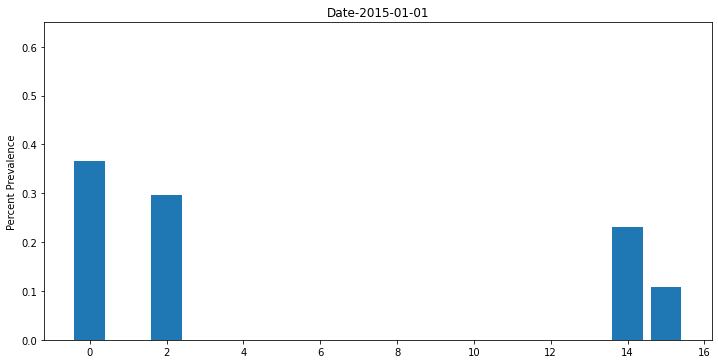

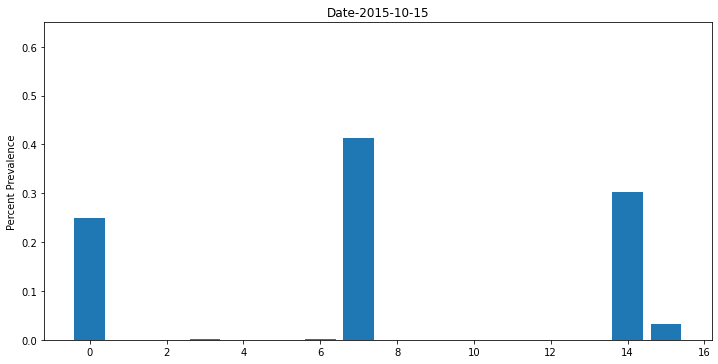

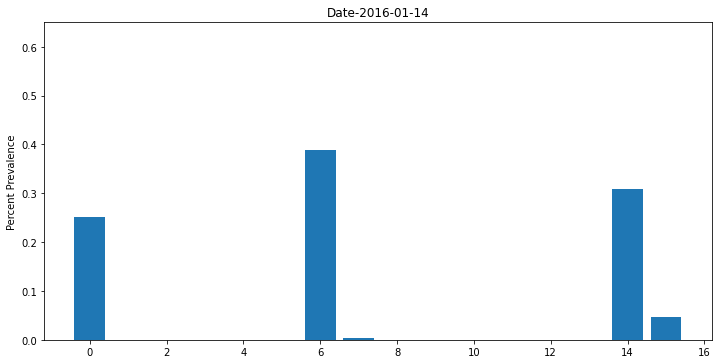

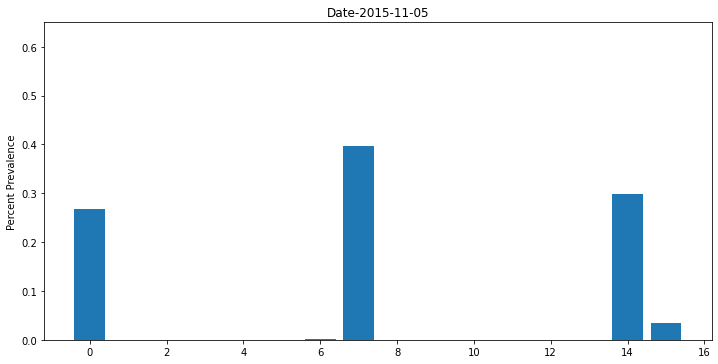

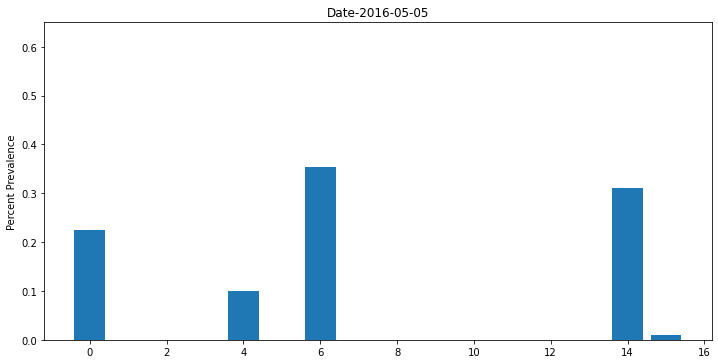

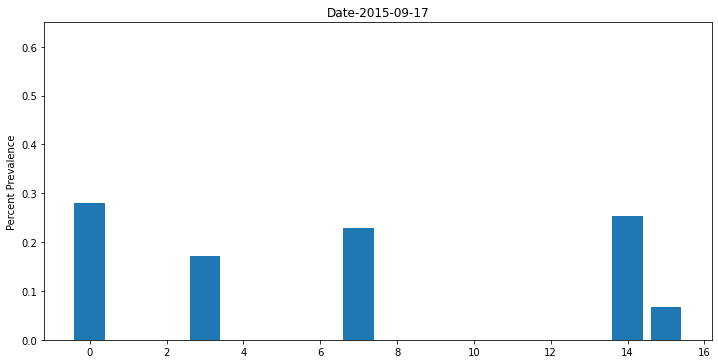

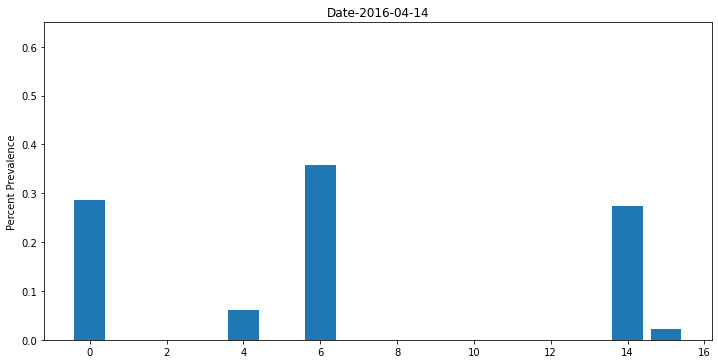

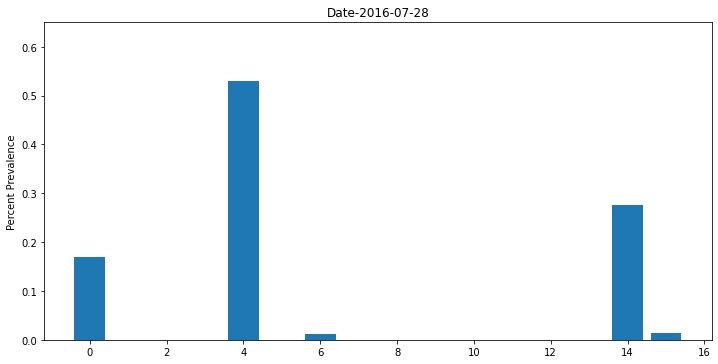

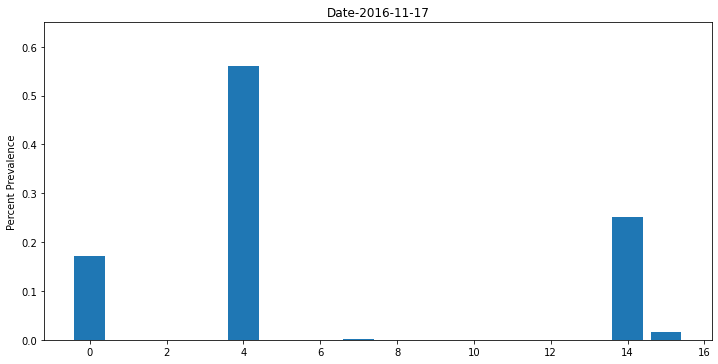

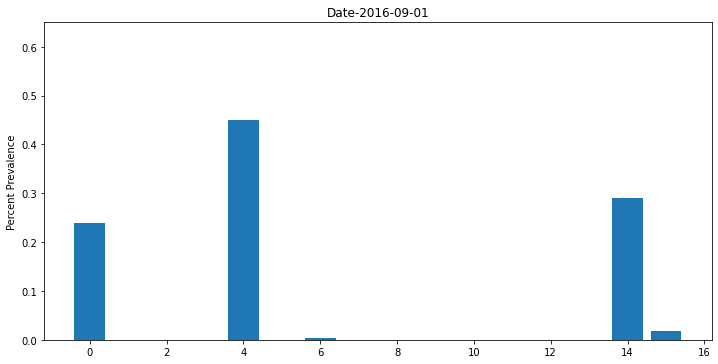

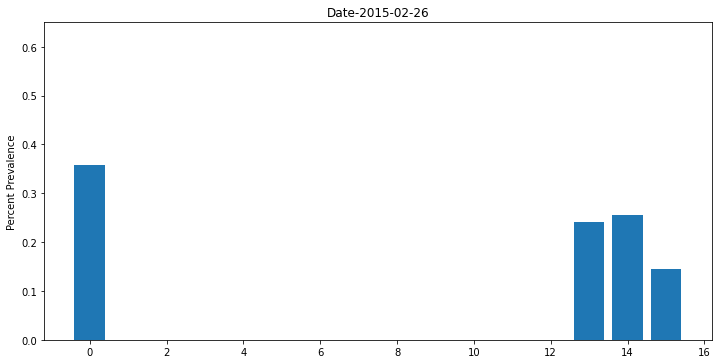

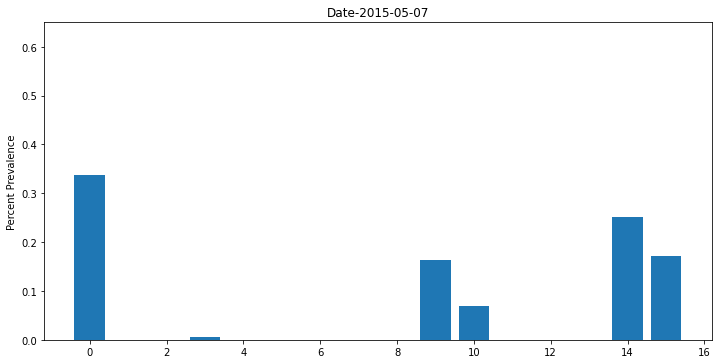

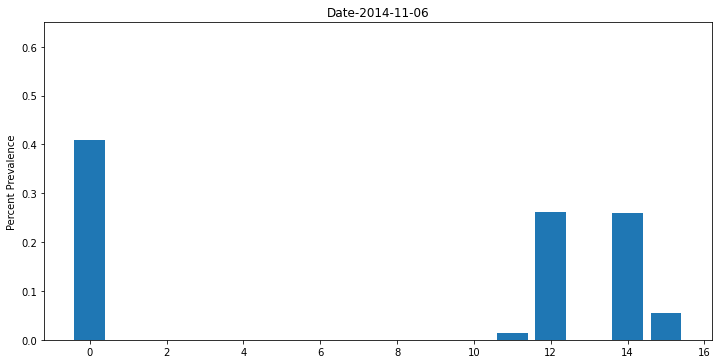

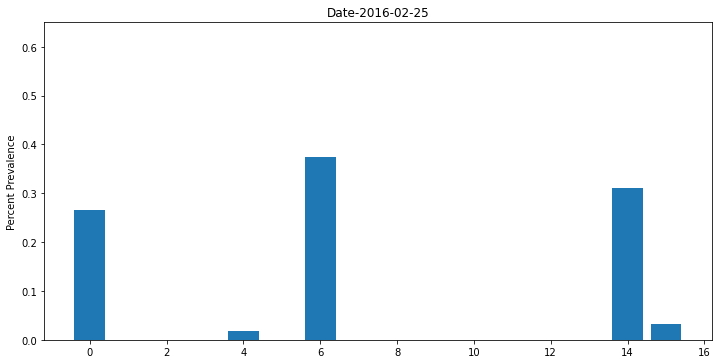

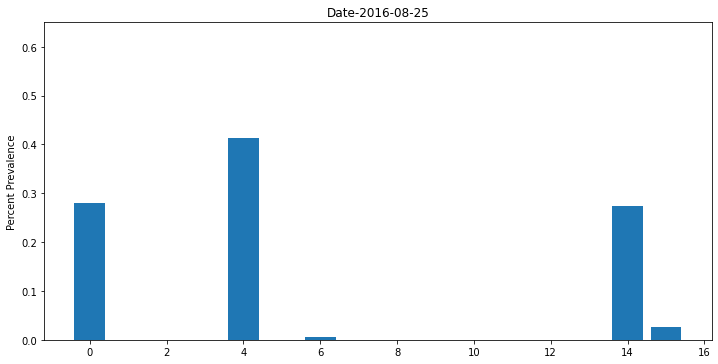

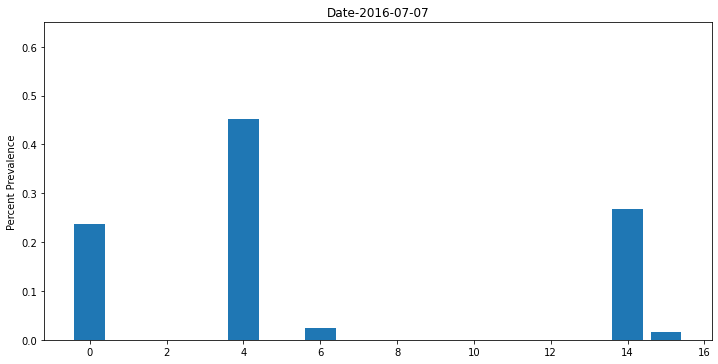

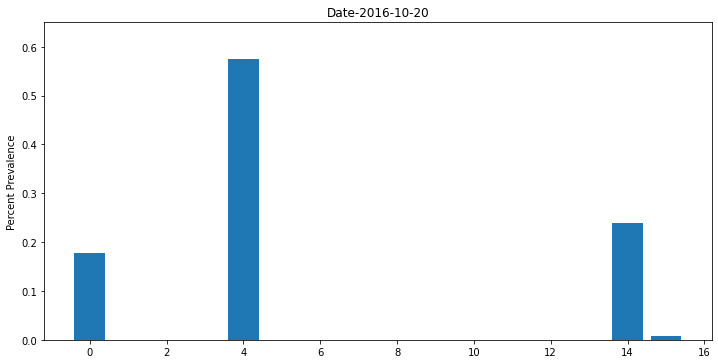

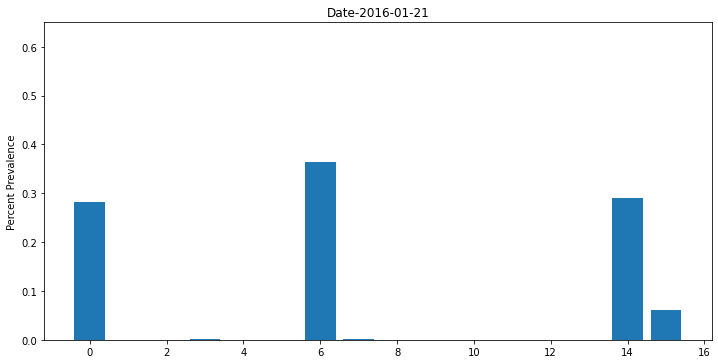

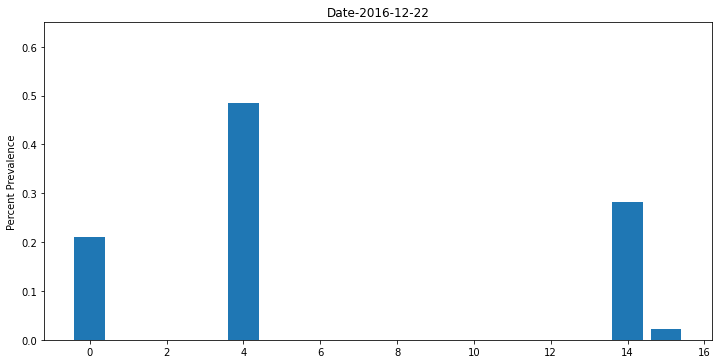

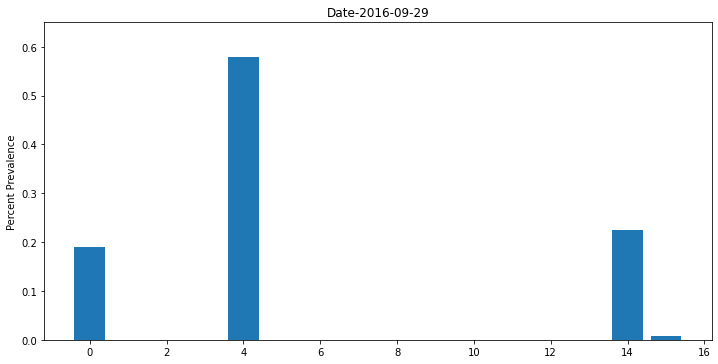

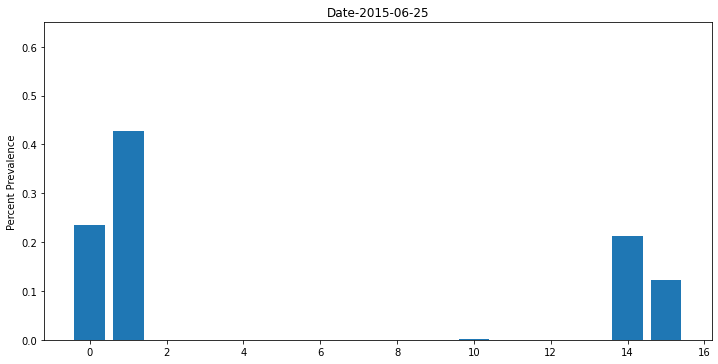

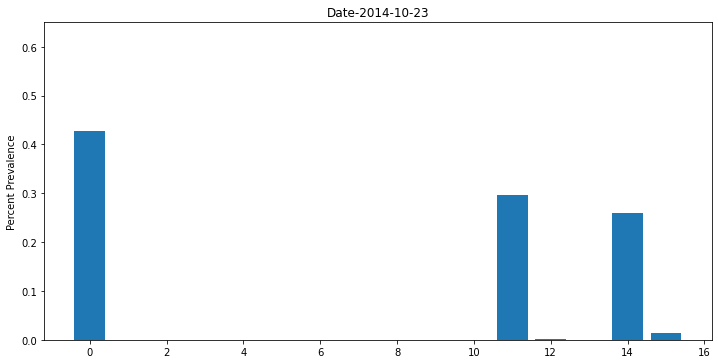

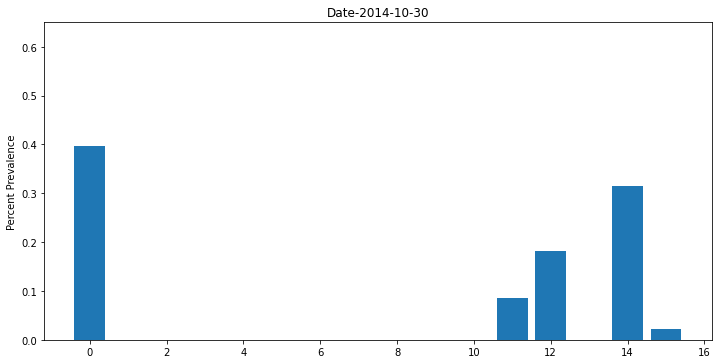

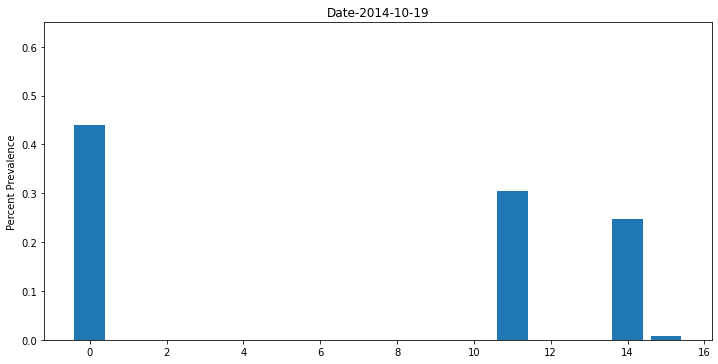

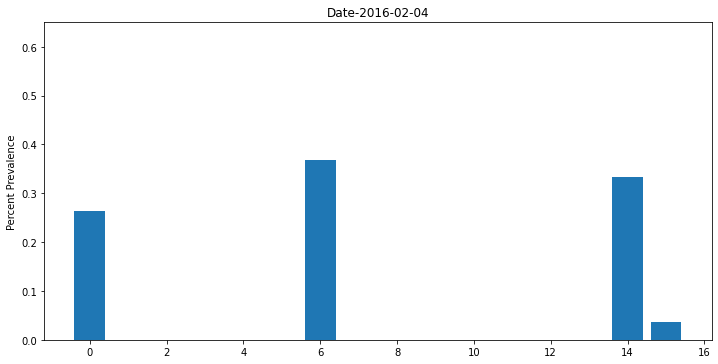

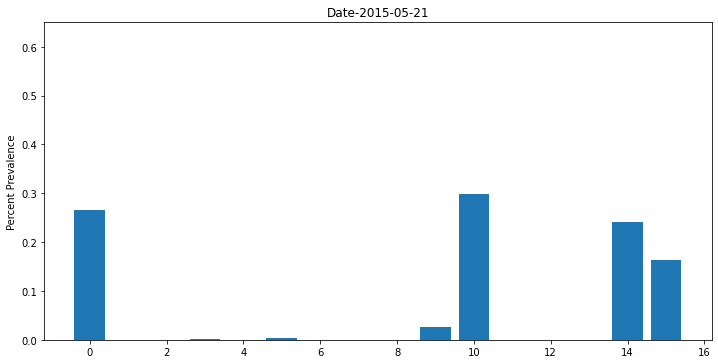

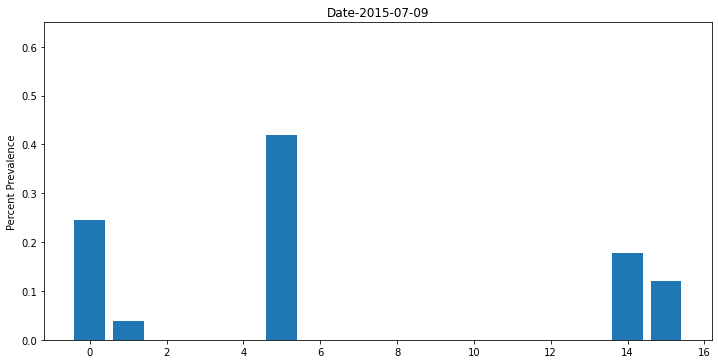

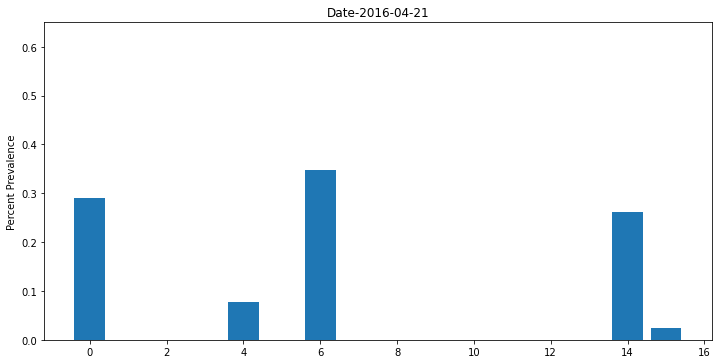

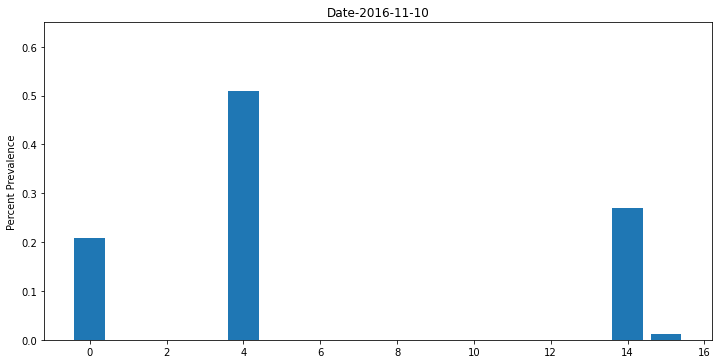

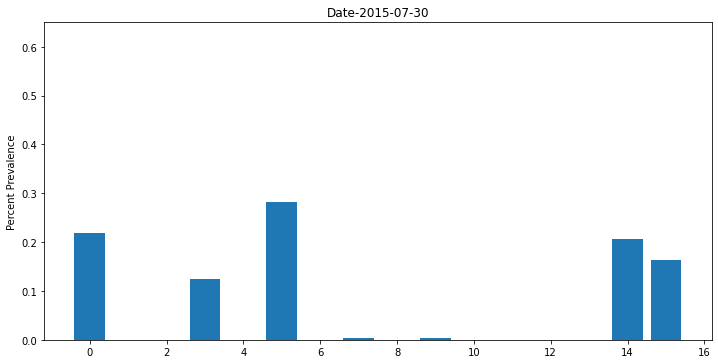

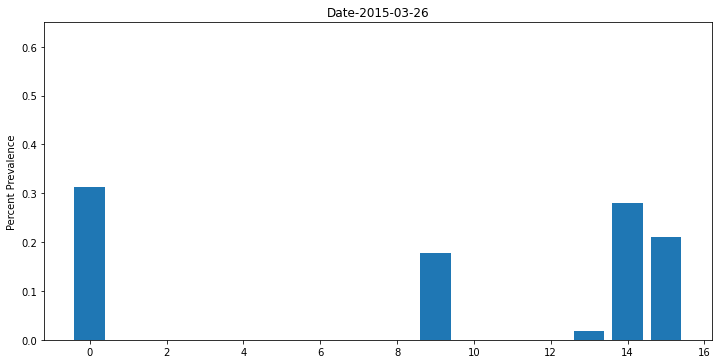

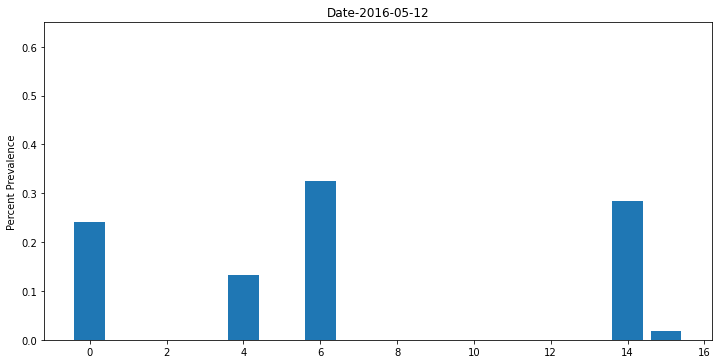

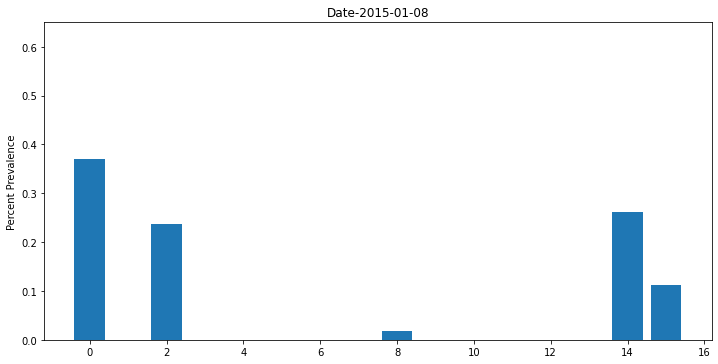

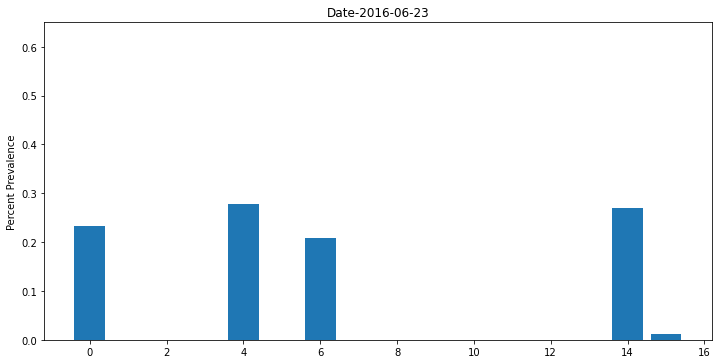

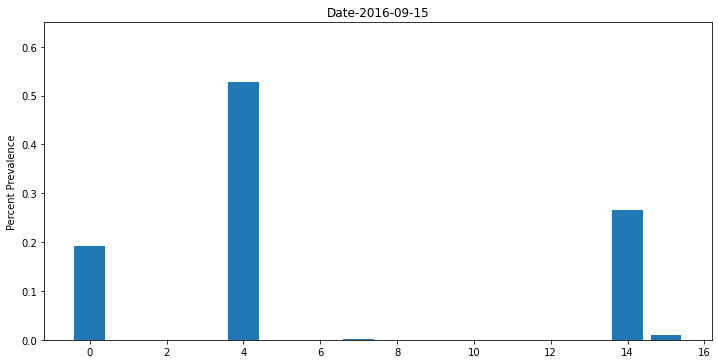

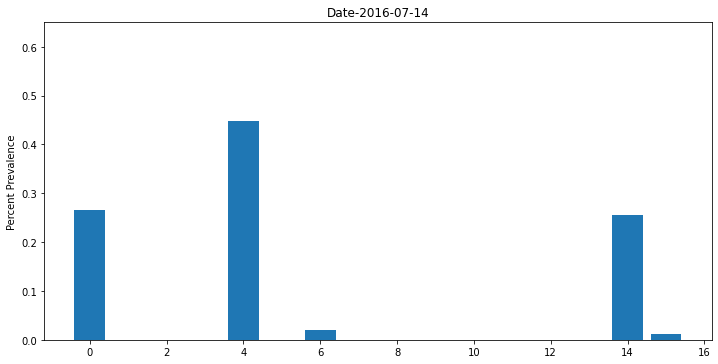

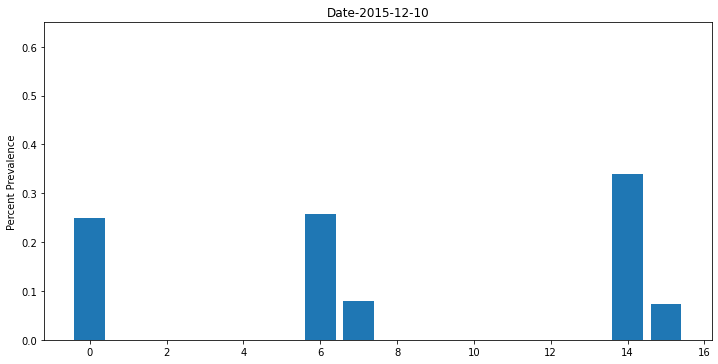

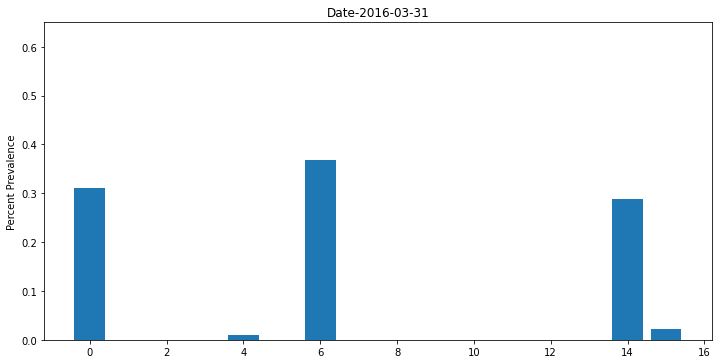

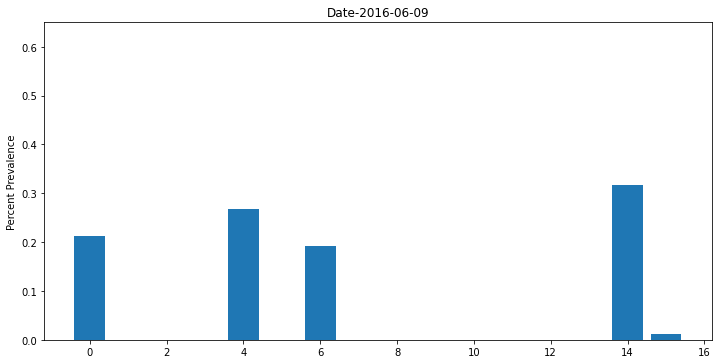

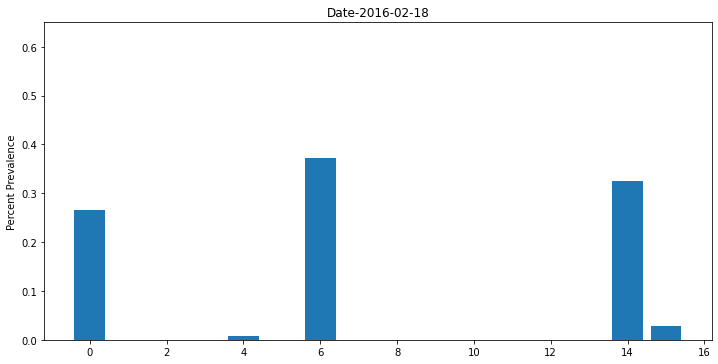

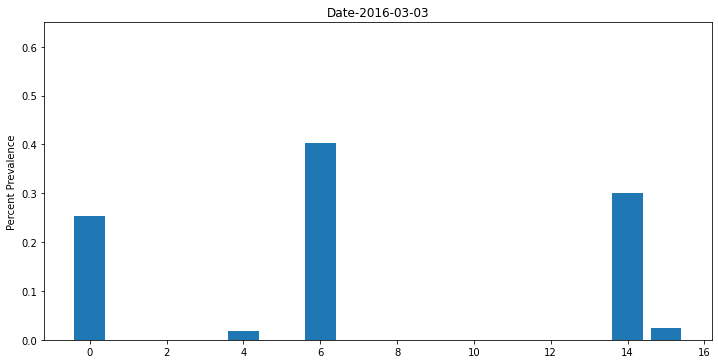

In [11]:
def graph_documents(data):
    for i in range(data.shape[0]):
        fig, axes = plt.subplots(1, 1, figsize=(10,5))
        fig.tight_layout(h_pad=5)
        axes.bar(range(16), data[i])
        axes.set_ylim([0,0.65])
        doc_name = names[i].split(".")[0]
        axes.set_title(f"Date-{doc_name}")
        axes.set_ylabel("Topic")
        axes.set_ylabel("Percent Prevalence")
        fig.savefig(f"{output_folder}/documents/document-{names[i]}.png")

graph_documents(topics)


In [ ]:
# Here we are going to graph each word individually.

# Get all tokens used in model
def get_tokens():
    """Gets all tokens used in model"""
    types = set()
    for doc, source, pos, typeindex, type_, topic in iterate_state():
        types.add(type_)
    return types

token = list(get_tokens())

# Generate a distribution of this word across all topics.
def word_frequency_graph(words):
    if not isinstance(words, list):
        words = [words]

    data = {word: {i: 0 for i in range(16)} for word in words}

    for doc, source, pos, typeindex, type_, topic in iterate_state():
        if type_ in data:
            data[type_][int(topic)] += 1

    for word in data:
        if len(data[word]) > 0:
            yield word, list(data[word].keys()), list(data[word].values())


# Graph a specific word
def graph(word, data, weights):
    if "/" not in word:
        path = pathlib.Path(f"{output_folder}/figures/{word}.png")
        if not path.exists():
            width = 0.75
            fig, axes = plt.subplots(1, 1, figsize=(25, 10))
            axes.set_xlim([-0.5,16])
            axes.set_ylim([0,1])
            axes.set_xlabel("Topic")
            axes.set_ylabel("Dist")
            axes.set_xticks(range(16))

            total = sum(weights)
            axes.bar([d for d in data], [(i / total) + 0.001 for i in weights], width, label=word)

            axes.legend()
            fig.savefig(f"{output_folder}/figures/{word}.png")
            plt.close(fig)

def multi_graph(word):
    with Parallel(n_jobs=-1) as p:
        p(delayed(graph)(*i) for i in word_frequency_graph(word))


multi_graph(token)